In [202]:
# Ignore the warnings
import warnings
# warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# System related and data input controls
import os

# Auto reload of library
%reload_ext autoreload
%autoreload 2

# Python path
import sys
base_folder = 'DataScience'
location_base = os.path.join(os.getcwd().split(base_folder)[0], base_folder)
location_module = [os.path.join(location_base, 'Module')] 
for each in location_module:
    if each not in sys.path:
        sys.path.append(each)

from import_KK import *
DeviceStrategy_CPU()
from data_KK import *
from description_KK import *
from preprocessing_KK import *
from preprocessing_text_KK import * ##
from algorithm_textmining_KK import * ##
from evaluation_KK import *
from visualization_KK import *

2025-02-17 01:47:59,711	INFO worker.py:1619 -- Calling ray.init() again after it has already been called.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KK\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\KK\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
2025-02-17 01:48:02,253	INFO worker.py:1619 -- Calling ray.init() again after it has already been called.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KK\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\KK\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
2025-02-17 01:48:04,725	INFO worker.py:1619 -- Calling ray.init() again after it has already been called.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\

Cuda is Ready?  False

Tensorflow Version:  2.18.0
Keras Version:  3.7.0
Torch Version:  2.5.1+cpu


In [199]:
def get_data_from_path(folder_location, folder_name=False, concat_axis='row', 
                       reset_index=False, date_column=None):
    # path_folder 하위의 모든 폴더위치와 내부 file 출력
    df = pd.DataFrame()
    print('Getting data from', len(os.listdir(folder_location)), 'folders...')
    for (path, dir, files) in os.walk(folder_location):
#         print(path)
        for file in tqdm(files):
            path_file = os.path.join(path, file)

            ## 데이터 로딩
            if path_file[-4:] == 'xlsx':
                df_sub = pd.read_excel(path_file)
            elif path_file[-3:] == 'csv':
                df_sub = pd.read_csv(path_file)
                
            ### 왓차피디어 변수명변경
            if 'reviewDate' in df_sub.columns:
                df_sub.rename(columns={'year':'date'}, inplace=True)
            elif 'writer' in df_sub.columns:
                df_sub.rename(columns={'writer':'username', 'comment':'review'}, inplace=True)

            ## 키워드 태깅 여부
            if folder_name:
                df_sub['Folder_Name'] = file 
                df_sub['Opening'] = os.path.basename(path).split('(')[1].split(')')[0]
                           
            ## 결합
            if concat_axis == 'col':
                df = pd.concat([df, df_sub], axis=1)
            elif concat_axis == 'row':
                df = pd.concat([df, df_sub], axis=0)
    
    # 정리
    if reset_index:
        df = df.reset_index().iloc[:,1:]
    if date_column != None:
        df[date_column] = pd.to_datetime(df[date_column])
                
    return df

# Hyperparameters

In [200]:
# 데이터 파라미터
TARGET = 'Comment'
CATEGORY = 'Viewing'
# 전처리모델 파라미터
STOPWORDS = ['정보 없음', '없음', '정보', '영화', '너무', '정말', 
             '눈물이', '봤어요', '봤습니다', '하는', '하고', '있는', '없다', 
             '보고', '이렇게', '대한', '보는', '그냥']
NGRAM_RANGE = (1,2)
TFIDF_MAXCOL = 5000
TFIDF_DELLOWFREQ = False
RAY = True
KEYBERT_TOPNKWD = 5
NUM_SHOWKEYWORD = 100
# 영화 필터링
FILTER_MOVIE = ['살인자의 기억법']
# 모델링 파라미터
TOKENIZER = 'KeyBERT'
# euclidean, manhattan, chebyshev, minkowski, canberra, braycurtis, mahalanobis, wminkowski, seuclidean, cosine, correlation
# haversine, hamming, jaccard, dice, russelrao, kulsinski, ll_dirichlet, hellinger, rogerstanimoto, sokalmichener, sokalsneath, yule
UMAP_METRIC = 'euclidean'
UMAP_SEED = 123
NUM_TOPICS = 'auto'
NUM_TOPICWORDS = 10
NUM_TOPICSAMPLES = 5
# 저장
SAVE_LOCAL = True
SAVE_NAME_PREP = 'wordfreq'
SAVE_NAME_LDA = 'Topics_byTokenLDA.xlsx'
SAVE_NAME_BERTopic = 'Topics_byBERTopic.xlsx'

# Data & Preprocessing

In [4]:
# # 데이터
# ## 로딩
# df = get_data_from_path(os.path.join(os.getcwd(), 'Data_Raw'), folder_name=True, concat_axis='row', 
#                         reset_index=True, date_column=None)
# ## 변수명 변환
# df.rename(columns={'Folder_Name':'Movie', 'username':'User', 'date':'Viewing', 'review':'Comment', 'rating':'Rating', 
#                    'likes':'Like', 'dislikes':'Dislike'}, inplace=True)
# ## 전처리
# df.Viewing = df.Viewing.apply(lambda x: str(x)[:4])
# df['Source'] = df.Movie.apply(lambda x: x.split('(')[1].split(')')[0])
# df.Source.replace({'네티즌':'Naver(Netizen)', '실관람객':'Naver(Audience)'}, inplace=True)
# df.Source = df.Source.apply(lambda x: 'Watcha' if len(x) == 4 else x)
# df.Movie = df.Movie.apply(lambda x: x.split('(')[0])
# df['Rating'] = df['Rating'].fillna('-1')
# df['Rating'] = df['Rating'].apply(lambda x: '-1' if x == '보고싶어요' else x)
# df['Rating'] = df['Rating'].apply(lambda x: '-1' if x == '보는 중' else x)
# df['Rating'] = df['Rating'].apply(lambda x: '-1' if x == '[]' else x)
# df['Rating'] = df['Rating'].apply(lambda x: float(x))
# df['Like'] = df['Like'].fillna('-1')
# df['Like'] = df['Like'].apply(lambda x: '-1' if x == '[]' else x)
# df['Like'] = df['Like'].apply(lambda x: int(str(x).replace(',','')))
# df['Dislike'] = df['Dislike'].fillna('-1')
# df['Dislike'] = df['Dislike'].apply(lambda x: int(x))
# df['Viewing'] = df['Viewing'].apply(lambda x: '-1' if x == '[]' else x)
# df['Viewing'] = df['Viewing'].apply(lambda x: 2024 if x in ['4시간 ', '5시간 ', '6시간 ', '7시간 ',
#                                                              '8시간 ', '9시간 ', '10시간', '16시간', 
#                                                              '18시간', '20시간', '24시간', '23시간'] else x)
# ## 삭제
# df.drop(columns=['url', 'reviewDate'], inplace=True)
# ## 결측치처리
# df_sub = df[~df.Like.isnull()].fillna(0)
# df = df.combine_first(df_sub)
# ## 정리
# df = df[['Movie', 'Opening', 'Source', 'User', 'Viewing', 'Rating', 'Like', 'Dislike', 'Comment']]
# ## 무의견 삭제
# df.dropna(subset=[TARGET], inplace=True)
# df = df[df[TARGET] != '']
# ## 중복 삭제
# df = df.drop_duplicates(keep='first').reset_index().iloc[:,1:]
# ## 텍스트 전처리
# df[TARGET+'_Prep'] = df[TARGET].progress_apply(lambda x: text_preprocessor(x, del_number=False, 
#                                                                            del_bracket_content=False,
#                                                                            stop_words=STOPWORDS))
# ## 정리
# df.dropna(subset=[TARGET+'_Prep'], inplace=True)
# df = df[df[TARGET+'_Prep'] != '']
# df = df[df[TARGET+'_Prep'] != 'nan']
# df = df.reset_index().iloc[:,1:]
# df.to_csv(os.path.join(os.getcwd(), 'Data', 'df_movie.csv'), index=False, encoding='utf-8-sig')

In [5]:
# ## 단어빈도 추출과 변환
# if FILTER_MOVIE != []:
#     ## 기초전처리 완료데이터 로딩
#     df = pd.read_csv(os.path.join(os.getcwd(), 'Data', 'df_movie.csv'), encoding='utf-8-sig')
#     df = df[~df.Movie.isin(FILTER_MOVIE)].reset_index().iloc[:,1:]
    
#     word_freq, wordadj_freq, df_freq = preprocessing_wordfreq(df, colname_target=TARGET+'_Prep', colname_category=None, 
#                                                               ngram_range=NGRAM_RANGE,
#                                                               tfidf_maxcol=TFIDF_MAXCOL, tfidf_dellowfreq=TFIDF_DELLOWFREQ,
#                                                               keybert_topnkwd=KEYBERT_TOPNKWD,
#                                                               sent2kwd_ray=RAY,
#                                                               num_showkeyword=NUM_SHOWKEYWORD, 
#                                                               save_local=SAVE_LOCAL, save_name=SAVE_NAME_PREP)
#     df_freq.to_csv(os.path.join(os.getcwd(), 'Data', 'df_moviefilter_prep_'+str(NGRAM_RANGE).replace(' ','')+'.csv'), index=False, encoding='utf-8-sig')
    
#     word_freq_categ, wordadj_freq_categ, df_freq_categ = preprocessing_wordfreq(df, colname_target=TARGET+'_Prep', colname_category=CATEGORY,
#                                                                     ngram_range=NGRAM_RANGE,
#                                                                     tfidf_maxcol=TFIDF_MAXCOL, tfidf_dellowfreq=TFIDF_DELLOWFREQ,
#                                                                     keybert_topnkwd=KEYBERT_TOPNKWD,
#                                                                     sent2kwd_ray=RAY,
#                                                                     num_showkeyword=NUM_SHOWKEYWORD, 
#                                                                     save_local=SAVE_LOCAL, save_name=SAVE_NAME_PREP)
#     df_freq_categ.to_csv(os.path.join(os.getcwd(), 'Data', 'df_moviefilter_prepcateg_'+str(NGRAM_RANGE).replace(' ','')+'.csv'), index=False, encoding='utf-8-sig')
# else:
#     ## 기초전처리 완료데이터 로딩
#     df = pd.read_csv(os.path.join(os.getcwd(), 'Data', 'df_movie.csv'), encoding='utf-8-sig')

#     word_freq, wordadj_freq, df_freq = preprocessing_wordfreq(df, colname_target=TARGET+'_Prep', colname_category=None, 
#                                                               ngram_range=NGRAM_RANGE,
#                                                               tfidf_maxcol=TFIDF_MAXCOL, tfidf_dellowfreq=TFIDF_DELLOWFREQ,
#                                                               keybert_topnkwd=KEYBERT_TOPNKWD,
#                                                               sent2kwd_ray=RAY,
#                                                               num_showkeyword=NUM_SHOWKEYWORD, 
#                                                               save_local=SAVE_LOCAL, save_name=SAVE_NAME_PREP)
#     df_freq.to_csv(os.path.join(os.getcwd(), 'Data', 'df_movie_prep_'+str(NGRAM_RANGE).replace(' ','')+'.csv'), index=False, encoding='utf-8-sig')
    
#     word_freq_categ, wordadj_freq_categ, df_freq_categ = preprocessing_wordfreq(df, colname_target=TARGET+'_Prep', colname_category=CATEGORY,
#                                                                     ngram_range=NGRAM_RANGE,
#                                                                     tfidf_maxcol=TFIDF_MAXCOL, tfidf_dellowfreq=TFIDF_DELLOWFREQ,
#                                                                     keybert_topnkwd=KEYBERT_TOPNKWD,
#                                                                     sent2kwd_ray=RAY,
#                                                                     num_showkeyword=NUM_SHOWKEYWORD, 
#                                                                     save_local=SAVE_LOCAL, save_name=SAVE_NAME_PREP)
#     df_freq_categ.to_csv(os.path.join(os.getcwd(), 'Data', 'df_movie_prepcateg_'+str(NGRAM_RANGE).replace(' ','')+'.csv'), index=False, encoding='utf-8-sig')

Preprocessing...: SoyNLP 2025-02-09 11:29:50.843759
training was done. used memory 1.266 Gbory 1.126 Gb
all cohesion probabilities was computed. # words = 40878
all branching entropies was computed # words = 53615
all accessor variety was computed # words = 53615
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 45691
_noun_scores_ 10468
after postprocessing 6157
Preprocessing...: TF-IDF 2025-02-09 11:33:25.289737
Preprocessing...: KeyBERT 2025-02-09 11:33:43.227270
Saving...: 2025-02-09 16:38:13.780982
Sentence to Keywords...: 2025-02-09 16:38:14.218141


2025-02-09 16:38:16,107	INFO worker.py:1619 -- Calling ray.init() again after it has already been called.
2025-02-09 16:39:50,851	INFO worker.py:1777 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
2025-02-09 16:42:52,042	INFO worker.py:1777 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Results Concat!: 2025-02-09 18:41:25.181295


Token by SoyNLP  Token by TF-IDF  Token by KeyBERT  \
Length             1554             5000            195597   

        Token(ADJ) by SoyNLP  Token(ADJ) by TF-IDF  Token(ADJ) by KeyBERT  
Length                  9067                 10000                   8510

word  score  word  score   word  score
0   기억   5881    다시    438    연기가    409
1   연기   5074    내가    434   재미있게    299
2   사람   3866   연기가    422  영화입니다    293
3  마지막   3366    진짜    418   아름다운    284
4   치매   3092  좋았어요    387   감동적인    246
5   가슴   2889    좋은    377   좋았어요    246
6   반전   2874    연기    375   배우들의    235
7   배우   2783   영화를    339   영화네요    218
8   눈물   2641    많이    337     감동    214
9   가장   2245    사랑    321    반전이    213

  0%|                                                                                           | 0/22 [00:00<?, ?it/s]

training was done. used memory 1.681 Gb1.681 Gb
all cohesion probabilities was computed. # words = 0
all branching entropies was computed # words = 0
all accessor variety was computed # words = 0
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 0
_noun_scores_ 0
after postprocessing 0


  5%|███▊                                                                               | 1/22 [00:02<00:59,  2.82s/it]

training was done. used memory 1.763 Gb1.763 Gb
all cohesion probabilities was computed. # words = 0
all branching entropies was computed # words = 0
all accessor variety was computed # words = 0
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 0
_noun_scores_ 0
after postprocessing 0


  9%|███████▌                                                                           | 2/22 [00:06<01:03,  3.16s/it]

training was done. used memory 1.765 Gb 1.765 Gb
all cohesion probabilities was computed. # words = 0
all branching entropies was computed # words = 0
all accessor variety was computed # words = 0
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 0
_noun_scores_ 0
after postprocessing 0


 14%|███████████▎                                                                       | 3/22 [00:11<01:18,  4.11s/it]

training was done. used memory 1.916 Gby 1.916 Gb
all cohesion probabilities was computed. # words = 26
all branching entropies was computed # words = 98
all accessor variety was computed # words = 98
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 56
_noun_scores_ 24
after postprocessing 12


 18%|███████████████                                                                    | 4/22 [00:42<04:28, 14.93s/it]

training was done. used memory 1.921 Gby 1.921 Gb
all cohesion probabilities was computed. # words = 49
all branching entropies was computed # words = 165
all accessor variety was computed # words = 165
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 86
_noun_scores_ 38
after postprocessing 20


 23%|██████████████████▊                                                                | 5/22 [01:42<08:48, 31.08s/it]

training was done. used memory 1.920 Gby 1.920 Gb
all cohesion probabilities was computed. # words = 26
all branching entropies was computed # words = 134
all accessor variety was computed # words = 134
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 57
_noun_scores_ 27
after postprocessing 16


 27%|██████████████████████▋                                                            | 6/22 [02:31<09:55, 37.25s/it]

training was done. used memory 2.088 Gb
all cohesion probabilities was computed. # words = 6
all branching entropies was computed # words = 41
all accessor variety was computed # words = 41
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 20
_noun_scores_ 12
after postprocessing 5


 32%|██████████████████████████▍                                                        | 7/22 [02:58<08:27, 33.83s/it]

training was done. used memory 2.093 Gby 2.093 Gb
all cohesion probabilities was computed. # words = 34
all branching entropies was computed # words = 152
all accessor variety was computed # words = 152
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 56
_noun_scores_ 23
after postprocessing 14


 36%|██████████████████████████████▏                                                    | 8/22 [03:42<08:38, 37.05s/it]

training was done. used memory 2.255 Gby 2.255 Gb
all cohesion probabilities was computed. # words = 71
all branching entropies was computed # words = 184
all accessor variety was computed # words = 184
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 102
_noun_scores_ 38
after postprocessing 27


 41%|█████████████████████████████████▉                                                 | 9/22 [04:27<08:32, 39.39s/it]

training was done. used memory 2.255 Gby 2.255 Gb
all cohesion probabilities was computed. # words = 78
all branching entropies was computed # words = 255
all accessor variety was computed # words = 255
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 147
_noun_scores_ 47
after postprocessing 30


 45%|█████████████████████████████████████▎                                            | 10/22 [05:17<08:32, 42.69s/it]

training was done. used memory 2.495 Gbry 2.495 Gb
all cohesion probabilities was computed. # words = 982
all branching entropies was computed # words = 1729
all accessor variety was computed # words = 1729
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 1250
_noun_scores_ 342
after postprocessing 204


 50%|████████████████████████████████████████▌                                        | 11/22 [11:50<27:30, 150.05s/it]

training was done. used memory 2.456 Gbry 2.456 Gb
all cohesion probabilities was computed. # words = 2782
all branching entropies was computed # words = 4151
all accessor variety was computed # words = 4151
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 3427
_noun_scores_ 990
after postprocessing 572


 55%|███████████████████████████████████████████                                    | 12/22 [31:49<1:18:09, 468.95s/it]

training was done. used memory 1.806 Gbory 1.806 Gb
all cohesion probabilities was computed. # words = 10368
all branching entropies was computed # words = 14416
all accessor variety was computed # words = 14416
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 11387
_noun_scores_ 2685
after postprocessing 1502


 59%|████████████████████████████████████████████▉                               | 13/22 [2:04:24<5:01:29, 2009.94s/it]

training was done. used memory 1.983 Gbry 1.982 Gb
all cohesion probabilities was computed. # words = 3846
all branching entropies was computed # words = 5925
all accessor variety was computed # words = 5925
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 4705
_noun_scores_ 1209
after postprocessing 688


 64%|████████████████████████████████████████████████▎                           | 14/22 [2:29:18<4:07:10, 1853.83s/it]

training was done. used memory 1.910 Gbry 1.910 Gb
all cohesion probabilities was computed. # words = 3366
all branching entropies was computed # words = 5286
all accessor variety was computed # words = 5286
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 4215
_noun_scores_ 1157
after postprocessing 690


 68%|███████████████████████████████████████████████████▊                        | 15/22 [2:49:48<3:14:22, 1666.07s/it]

training was done. used memory 1.853 Gbry 1.852 Gb
all cohesion probabilities was computed. # words = 4724
all branching entropies was computed # words = 7019
all accessor variety was computed # words = 7019
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 5639
_noun_scores_ 1485
after postprocessing 875


 73%|███████████████████████████████████████████████████████▎                    | 16/22 [3:07:48<2:28:57, 1489.54s/it]

training was done. used memory 1.864 Gbry 1.864 Gb
all cohesion probabilities was computed. # words = 5590
all branching entropies was computed # words = 8094
all accessor variety was computed # words = 8094
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 6566
_noun_scores_ 1680
after postprocessing 968


 77%|██████████████████████████████████████████████████████████▋                 | 17/22 [3:29:37<1:59:35, 1435.10s/it]

training was done. used memory 1.491 Gbry 1.486 Gb
all cohesion probabilities was computed. # words = 8436
all branching entropies was computed # words = 12184
all accessor variety was computed # words = 12184
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 9802
_noun_scores_ 2491
after postprocessing 1436


 82%|██████████████████████████████████████████████████████████████▏             | 18/22 [4:17:43<2:04:44, 1871.19s/it]

training was done. used memory 1.460 Gbry 1.459 Gb
all cohesion probabilities was computed. # words = 6981
all branching entropies was computed # words = 10091
all accessor variety was computed # words = 10091
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 8027
_noun_scores_ 2014
after postprocessing 1172


 86%|█████████████████████████████████████████████████████████████████▋          | 19/22 [4:50:34<1:35:03, 1901.24s/it]

training was done. used memory 1.256 Gbry 1.242 Gb
all cohesion probabilities was computed. # words = 4536
all branching entropies was computed # words = 7029
all accessor variety was computed # words = 7029
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 5344
_noun_scores_ 1382
after postprocessing 832


 91%|██████████████████████████████████████████████████████████████████████▉       | 20/22 [5:12:53<57:44, 1732.45s/it]

training was done. used memory 1.349 Gbry 1.348 Gb
all cohesion probabilities was computed. # words = 3083
all branching entropies was computed # words = 5169
all accessor variety was computed # words = 5169
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 3700
_noun_scores_ 1010
after postprocessing 583


 95%|██████████████████████████████████████████████████████████████████████████▍   | 21/22 [5:26:33<24:18, 1458.39s/it]

training was done. used memory 1.362 Gbry 1.361 Gb
all cohesion probabilities was computed. # words = 5530
all branching entropies was computed # words = 8775
all accessor variety was computed # words = 8775
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 6669
_noun_scores_ 1768
after postprocessing 1001



00%|███████████████████████████████████████████████████████████████████████████████| 22/22 [5:54:38<00:00, 967.22s/it]

Saving...: 2025-02-10 00:36:04.807733
Sentence to Keywords...: 2025-02-10 00:36:05.621237


2025-02-10 00:36:10,543	INFO worker.py:1777 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
2025-02-10 00:38:31,940	INFO worker.py:1777 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
2025-02-10 01:14:01,521	INFO worker.py:1777 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Results Concat!: 2025-02-10 03:25:42.519960


Token by SoyNLP  Token by TF-IDF  Token by KeyBERT  \
Length             2718            68845            226446   

        Token(ADJ) by SoyNLP  Token(ADJ) by TF-IDF  Token(ADJ) by KeyBERT  
Length                 33506                 78750                   9537

category word  score category      word  score category         word  score
0     2007   영화     18     2003       감동이      0     2003   잔잔하지만 오래도록      0
1     2007  마지막     16     2003    감동이 남는      0     2003        잔잔하지만      0
2     2007   일본      7     2003        남는      0     2003     오래도록 감동이      0
3     2011   사랑     19     2003    남는 따스한      0     2003       감동이 남는      0
4     2011   가슴     16     2003       따스한      0     2003         영화강추      0
5     2011   엄마     12     2003  따스한 영화강추      0     2004  정도다너무도 감동적인      0
6     2012   눈물     23     2003      영화강추      0     2004  드니로로빈 월리암스가      0
7     2012   아름     18     2003      오래도록      0     2004    여자주인공이 왠지      0
8     2012   감동     14     2003  오래도록 감동이      0     2004       나는 행동에      0
9     2012   내용      8     2003     잔잔하지만      0     2004    월리암스가 나온다      0

In [203]:
## 단어빈도 추출과 변환
if FILTER_MOVIE != []:
    ## 기초전처리 완료데이터 로딩
    df = pd.read_csv(os.path.join(os.getcwd(), 'Data', 'df_movie.csv'), encoding='utf-8-sig')
    df = df[~df.Movie.isin(FILTER_MOVIE)].reset_index().iloc[:,1:]
    
    word_freq, wordadj_freq, df_freq = preprocessing_wordfreq(df, colname_target=TARGET+'_Prep', colname_category=None, 
                                                              ngram_range=NGRAM_RANGE,
                                                              tfidf_maxcol=TFIDF_MAXCOL, tfidf_dellowfreq=TFIDF_DELLOWFREQ,
                                                              keybert_topnkwd=KEYBERT_TOPNKWD,
                                                              num_showkeyword=NUM_SHOWKEYWORD, 
                                                              save_local=SAVE_LOCAL, save_name=SAVE_NAME_PREP)
    df_freq.to_csv(os.path.join(os.getcwd(), 'Data', 'df_moviefilter_prep_'+str(NGRAM_RANGE).replace(' ','')+'.csv'), index=False, encoding='utf-8-sig')
    
    word_freq_categ, wordadj_freq_categ, df_freq_categ = preprocessing_wordfreq(df, colname_target=TARGET+'_Prep', colname_category=CATEGORY,
                                                                    ngram_range=NGRAM_RANGE,
                                                                    tfidf_maxcol=TFIDF_MAXCOL, tfidf_dellowfreq=TFIDF_DELLOWFREQ,
                                                                    keybert_topnkwd=KEYBERT_TOPNKWD,
                                                                    num_showkeyword=NUM_SHOWKEYWORD, 
                                                                    save_local=SAVE_LOCAL, save_name=SAVE_NAME_PREP)
    df_freq_categ.to_csv(os.path.join(os.getcwd(), 'Data', 'df_moviefilter_prepcateg_'+str(NGRAM_RANGE).replace(' ','')+'.csv'), index=False, encoding='utf-8-sig')
else:
    ## 기초전처리 완료데이터 로딩
    df = pd.read_csv(os.path.join(os.getcwd(), 'Data', 'df_movie.csv'), encoding='utf-8-sig')

    word_freq, wordadj_freq, df_freq = preprocessing_wordfreq(df, colname_target=TARGET+'_Prep', colname_category=None, 
                                                              ngram_range=NGRAM_RANGE,
                                                              tfidf_maxcol=TFIDF_MAXCOL, tfidf_dellowfreq=TFIDF_DELLOWFREQ,
                                                              keybert_topnkwd=KEYBERT_TOPNKWD,
                                                              num_showkeyword=NUM_SHOWKEYWORD, 
                                                              save_local=SAVE_LOCAL, save_name=SAVE_NAME_PREP)
    df_freq.to_csv(os.path.join(os.getcwd(), 'Data', 'df_movie_prep_'+str(NGRAM_RANGE).replace(' ','')+'.csv'), index=False, encoding='utf-8-sig')
    
    word_freq_categ, wordadj_freq_categ, df_freq_categ = preprocessing_wordfreq(df, colname_target=TARGET+'_Prep', colname_category=CATEGORY,
                                                                    ngram_range=NGRAM_RANGE,
                                                                    tfidf_maxcol=TFIDF_MAXCOL, tfidf_dellowfreq=TFIDF_DELLOWFREQ,
                                                                    keybert_topnkwd=KEYBERT_TOPNKWD,
                                                                    num_showkeyword=NUM_SHOWKEYWORD, 
                                                                    save_local=SAVE_LOCAL, save_name=SAVE_NAME_PREP)
    df_freq_categ.to_csv(os.path.join(os.getcwd(), 'Data', 'df_movie_prepcateg_'+str(NGRAM_RANGE).replace(' ','')+'.csv'), index=False, encoding='utf-8-sig')

Preprocessing...: SoyNLP 2025-02-17 01:48:18.214362
training was done. used memory 4.216 Gbory 4.144 Gb
all cohesion probabilities was computed. # words = 40878
all branching entropies was computed # words = 53615
all accessor variety was computed # words = 53615
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 45691
_noun_scores_ 10468
after postprocessing 6157
Preprocessing...: TF-IDF 2025-02-17 01:51:42.199257
Preprocessing...: KeyBERT 2025-02-17 01:52:00.251845
Saving...: 2025-02-17 07:00:28.091521
Sentence to Keywords...: 2025-02-17 07:00:28.477828





00%|████████████████████████████████████████████████████████████████████████████| 60803/60803 [38:45<00:00, 26.15it/s]

Results Concat!: 2025-02-17 07:40:17.941524


Token by SoyNLP  Token by TF-IDF  Token by KeyBERT  \
Length             1554             5000            195597   

        Token(ADJ) by SoyNLP  Token(ADJ) by TF-IDF  Token(ADJ) by KeyBERT  
Length                  8072                  9898                   7973

word  score  word  score   word  score
0   기억   5881    다시    438    연기가    409
1   연기   5074    내가    434   재미있게    299
2   사람   3866   연기가    422  영화입니다    293
3  마지막   3366    진짜    418   아름다운    284
4   치매   3092  좋았어요    387   감동적인    246
5   가슴   2889    좋은    377   좋았어요    246
6   반전   2874    연기    375   배우들의    235
7   배우   2783   영화를    339   영화네요    218
8   눈물   2641    많이    337     감동    214
9   가장   2245    사랑    321    반전이    213

  0%|                                                                                           | 0/22 [00:00<?, ?it/s]

training was done. used memory 4.529 Gb4.529 Gb
all cohesion probabilities was computed. # words = 0
all branching entropies was computed # words = 0
all accessor variety was computed # words = 0
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 0
_noun_scores_ 0
after postprocessing 0


  5%|███▊                                                                               | 1/22 [00:03<01:06,  3.16s/it]

training was done. used memory 4.608 Gb4.608 Gb
all cohesion probabilities was computed. # words = 0
all branching entropies was computed # words = 0
all accessor variety was computed # words = 0
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 0
_noun_scores_ 0
after postprocessing 0


  9%|███████▌                                                                           | 2/22 [00:06<01:08,  3.43s/it]

training was done. used memory 4.614 Gb 4.614 Gb
all cohesion probabilities was computed. # words = 0
all branching entropies was computed # words = 0
all accessor variety was computed # words = 0
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 0
_noun_scores_ 0
after postprocessing 0


 14%|███████████▎                                                                       | 3/22 [00:11<01:18,  4.12s/it]

training was done. used memory 4.763 Gby 4.763 Gb
all cohesion probabilities was computed. # words = 26
all branching entropies was computed # words = 98
all accessor variety was computed # words = 98
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 56
_noun_scores_ 24
after postprocessing 12


 18%|███████████████                                                                    | 4/22 [00:43<04:28, 14.91s/it]

training was done. used memory 4.764 Gby 4.764 Gb
all cohesion probabilities was computed. # words = 49
all branching entropies was computed # words = 165
all accessor variety was computed # words = 165
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 86
_noun_scores_ 38
after postprocessing 20


 23%|██████████████████▊                                                                | 5/22 [01:27<07:15, 25.61s/it]

training was done. used memory 4.766 Gby 4.766 Gb
all cohesion probabilities was computed. # words = 26
all branching entropies was computed # words = 134
all accessor variety was computed # words = 134
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 57
_noun_scores_ 27
after postprocessing 16


 27%|██████████████████████▋                                                            | 6/22 [01:59<07:24, 27.76s/it]

training was done. used memory 4.937 Gb
all cohesion probabilities was computed. # words = 6
all branching entropies was computed # words = 41
all accessor variety was computed # words = 41
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 20
_noun_scores_ 12
after postprocessing 5


 32%|██████████████████████████▍                                                        | 7/22 [02:18<06:13, 24.90s/it]

training was done. used memory 4.943 Gby 4.943 Gb
all cohesion probabilities was computed. # words = 34
all branching entropies was computed # words = 152
all accessor variety was computed # words = 152
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 56
_noun_scores_ 23
after postprocessing 14


 36%|██████████████████████████████▏                                                    | 8/22 [02:50<06:18, 27.00s/it]

training was done. used memory 4.955 Gby 4.955 Gb
all cohesion probabilities was computed. # words = 71
all branching entropies was computed # words = 184
all accessor variety was computed # words = 184
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 102
_noun_scores_ 38
after postprocessing 27


 41%|█████████████████████████████████▉                                                 | 9/22 [03:34<07:00, 32.37s/it]

training was done. used memory 5.102 Gby 5.102 Gb
all cohesion probabilities was computed. # words = 78
all branching entropies was computed # words = 255
all accessor variety was computed # words = 255
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 147
_noun_scores_ 47
after postprocessing 30


 45%|█████████████████████████████████████▎                                            | 10/22 [04:25<07:38, 38.20s/it]

training was done. used memory 5.179 Gbry 5.179 Gb
all cohesion probabilities was computed. # words = 982
all branching entropies was computed # words = 1729
all accessor variety was computed # words = 1729
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 1250
_noun_scores_ 342
after postprocessing 204


 50%|████████████████████████████████████████▌                                        | 11/22 [09:54<23:19, 127.26s/it]

training was done. used memory 5.315 Gbry 5.315 Gb
all cohesion probabilities was computed. # words = 2782
all branching entropies was computed # words = 4151
all accessor variety was computed # words = 4151
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 3427
_noun_scores_ 990
after postprocessing 572


 55%|████████████████████████████████████████████▏                                    | 12/22 [24:37<59:29, 356.99s/it]

training was done. used memory 5.500 Gbory 5.497 Gb
all cohesion probabilities was computed. # words = 10368
all branching entropies was computed # words = 14416
all accessor variety was computed # words = 14416
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 11387
_noun_scores_ 2685
after postprocessing 1502


 59%|████████████████████████████████████████████▉                               | 13/22 [1:31:22<3:39:19, 1462.14s/it]

training was done. used memory 4.832 Gbry 4.832 Gb
all cohesion probabilities was computed. # words = 3846
all branching entropies was computed # words = 5925
all accessor variety was computed # words = 5925
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 4705
_noun_scores_ 1209
after postprocessing 688


 64%|████████████████████████████████████████████████▎                           | 14/22 [1:49:24<2:59:37, 1347.22s/it]

training was done. used memory 4.918 Gbry 4.918 Gb
all cohesion probabilities was computed. # words = 3366
all branching entropies was computed # words = 5286
all accessor variety was computed # words = 5286
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 4215
_noun_scores_ 1157
after postprocessing 690


 68%|███████████████████████████████████████████████████▊                        | 15/22 [2:04:45<2:22:11, 1218.75s/it]

training was done. used memory 4.690 Gbry 4.690 Gb
all cohesion probabilities was computed. # words = 4724
all branching entropies was computed # words = 7019
all accessor variety was computed # words = 7019
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 5639
_noun_scores_ 1485
after postprocessing 875


 73%|███████████████████████████████████████████████████████▎                    | 16/22 [2:25:30<2:02:40, 1226.77s/it]

training was done. used memory 4.928 Gbry 4.928 Gb
all cohesion probabilities was computed. # words = 5590
all branching entropies was computed # words = 8094
all accessor variety was computed # words = 8094
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 6566
_noun_scores_ 1680
after postprocessing 968




KeyboardInterrupt

█████████████████████████████████████████▍                     | 16/22 [2:37:28<59:03, 590.56s/it]

In [4]:
if FILTER_MOVIE != []:
    df_freq = pd.read_csv(os.path.join('.', 'Data', 'df_moviefilter_prep_'+str(NGRAM_RANGE).replace(' ','')+'.csv'), encoding='utf-8-sig')
    df_freq_categ = pd.read_csv(os.path.join('.', 'Data', 'df_moviefilter_prepcateg_'+str(NGRAM_RANGE).replace(' ','')+'.csv'), encoding='utf-8-sig')
    word_freq = pd.read_csv(os.path.join('.', 'Result', 'WordFreq', 'Filter', 'wordfreq_'+TOKENIZER.lower()+'.csv'), encoding='utf-8-sig')
    wordadj_freq = pd.read_csv(os.path.join('.', 'Result', 'WordFreq', 'Filter', 'wordfreq_'+TOKENIZER.lower()+'adj.csv'), encoding='utf-8-sig')
    word_freq_categ = pd.read_csv(os.path.join('.', 'Result', 'WordFreq', 'Filter', 'wordfreqcateg_'+TOKENIZER.lower()+'.csv'), encoding='utf-8-sig')
    wordadj_freq_categ = pd.read_csv(os.path.join('.', 'Result', 'WordFreq', 'Filter', 'wordfreqcateg_'+TOKENIZER.lower()+'adj.csv'), encoding='utf-8-sig')
else:
    df_freq = pd.read_csv(os.path.join('.', 'Data', 'df_movie_prep_'+str(NGRAM_RANGE).replace(' ','')+'.csv'), encoding='utf-8-sig')
    df_freq_categ = pd.read_csv(os.path.join('.', 'Data', 'df_movie_prepcateg_'+str(NGRAM_RANGE).replace(' ','')+'.csv'), encoding='utf-8-sig')
    word_freq = pd.read_csv(os.path.join('.', 'Result', 'WordFreq', 'Total', 'wordfreq_'+TOKENIZER.lower()+'.csv'), encoding='utf-8-sig')
    wordadj_freq = pd.read_csv(os.path.join('.', 'Result', 'WordFreq', 'Total', 'wordfreq_'+TOKENIZER.lower()+'adj.csv'), encoding='utf-8-sig')
    word_freq_categ = pd.read_csv(os.path.join('.', 'Result', 'WordFreq', 'Total', 'wordfreqcateg_'+TOKENIZER.lower()+'.csv'), encoding='utf-8-sig')
    wordadj_freq_categ = pd.read_csv(os.path.join('.', 'Result', 'WordFreq', 'Total', 'wordfreqcateg_'+TOKENIZER.lower()+'adj.csv'), encoding='utf-8-sig')

In [190]:
df_coword_adjcent, df_coword_direct, df_coword_pair = preprocessing_sent2cooccurmat(df_freq['Comment_Prep'][:5000], 
                                                                                    word_freq=word_freq.iloc[:,:])
df_coword_adjcent

sentence to cooccurent matrix...




00%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:16<00:00, 298.15it/s]

final arrange...


word  score
0                       연기가 좋았다      4
1                     연기가 좋았습니다      3
2                      연기가 좋았어요      2
3                      연기가 돋보이는      2
4                       연기가 따뜻한      2
...                         ...    ...
22073                  잘했다는 생각이      1
22074                   경계 3부작의      2
22075                    경계 사랑의      1
22076                     경계 나는      1
22077  안잤음재밌다고이모들효티켓예매일상의 소중함추천      1

[22078 rows x 2 columns]

In [196]:
   
df_test1, df_test2 = preprocessing_adjwordcount(word_freq.iloc[:,0:1], df_freq['Comment_Prep'][:5000], num_showkeyword=1000)
display(df_test1, df_test2)

2025-02-17 01:39:50,427	INFO worker.py:1619 -- Calling ray.init() again after it has already been called.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KK\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\KK\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
2025-02-17 01:39:54,952	INFO worker.py:1619 -- Calling ray.init() again after it has already been called.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KK\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\KK\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


word  score
0       연기가 좋았다      4
1     연기가 좋았습니다      3
2      연기가 돋보이는      2
3      연기가 잊혀지지      2
4         연기가 다      2
...         ...    ...
8780     그대를 사랑      1
8781      그대를 늘      1
8782     그대를 않다      1
8783   그대를 가슴으로      1
8784    그대를 나또한      1

[8785 rows x 2 columns]

word  score
0        연기가 배우들의     14
1         연기가 좋았다      4
2        연기가 손예진의      3
3       연기가 좋았습니다      3
4        연기가 배우님의      2
...           ...    ...
15504       그대를 늘      1
15505    그대를 늙어서도      1
15506  그대를 스며들어버린      1
15507      그대를 고백      1
15508      그대를 사랑      1

[15509 rows x 2 columns]

In [85]:
import networkx as nx
from pyvis.network import Network
import nxviz as nv

kw_top_display = 10

# word matrix data
df_wordvec, df_wordcorr, df_wordcorrpair = freq2vectorcorr_preprocessor(df_freq['Comment_Prep'], word_freq, 
                                                                        num_showkeyword=20, relation_type='corr')

In [86]:
## 'size', 'value', 'title', 'x', 'y', 'label', 'color'
## select_menu=True, filter_menu=True
net = Network(notebook=True)
net.barnes_hut()
for row in df_wordcorrpair.values:
    if row[-1] > df_wordcorrpair.score.mean():
        net.add_node(n_id=row[0], label=row[0], title=row[0], labelHighlightBold=True)
        net.add_node(n_id=row[1], label=row[1], title=row[1], labelHighlightBold=True)
        net.add_edge(source=row[0], to=row[1], value=row[2])

net.show_buttons(filter_=['physics'])
# net.toggle_physics(True)
net.show('test.html')

test.html


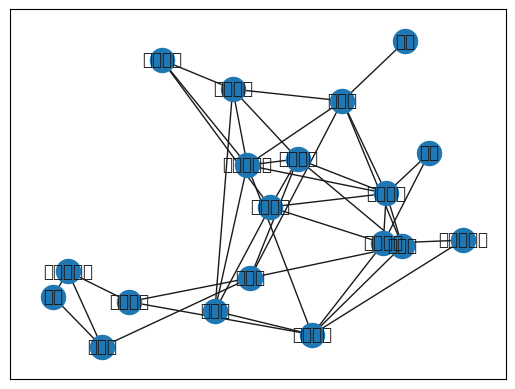

In [104]:
# graph data
# ## pyvis
# ## 'size', 'value', 'title', 'x', 'y', 'label', 'color'
# ## select_menu=True, filter_menu=True
# net = Network(notebook=True)
# net.barnes_hut()
# for row in df_wordcorrpair.values:
#     if row[-1] > df_wordcorrpair.score.mean():
#         net.add_node(n_id=row[0], label=row[0], title=row[0], labelHighlightBold=True)
#         net.add_node(n_id=row[1], label=row[1], title=row[1], labelHighlightBold=True)
#         net.add_edge(source=row[0], to=row[1], value=row[2])
## networkx
## https://networkx.org/documentation/stable//reference/generators.html
g = nx.Graph()
## graph generate
for row in df_wordcorrpair.values:
    if row[-1] > df_wordcorrpair.score.mean():
        g.add_edge(row[0], row[1], weight=row[2])
## descriptive
## 연결된 노드가 많은 note 중요성 파악
dc = nx.degree_centrality(g)
dc = sorted(dc.items(), key=lambda x:x[1], reverse=True)
dc = pd.DataFrame(list(dc), columns=['word', 'degree of centality'])
## 집단을 이어주는 경우가 많은 node 파악
bc = nx.betweenness_centrality(g, weight='weight')
bc = sorted(bc.items(), key=lambda x:x[1], reverse=True)
bc = pd.DataFrame(list(bc), columns=['word', 'betweenness of centality'])
## 다른 node들과 얼마가 가깝게 연결되어 연관어들의 연관성 node 파악
cc = nx.closeness_centrality(g)
cc = sorted(cc.items(), key=lambda x:x[1], reverse=True)
cc = pd.DataFrame(list(cc), columns=['word', 'closeness of centality'])
## dc와 유사한데 follow가 많은 사람들에 의해 follow가 되는 node 가중치
ec = nx.eigenvector_centrality(g, weight='weight')
ec = sorted(ec.items(), key=lambda x:x[1], reverse=True)
ec = pd.DataFrame(list(ec), columns=['word', 'eigenvector of centality'])
## 다른 node의 중심성과 연결된 상대적 갯수로 최적화된 node 파악
pr = nx.pagerank(g)
pr = sorted(pr.items(), key=lambda x:x[1], reverse=True)
pr = pd.DataFrame(list(pr), columns=['word', 'page rank'])

# visualization
# nv.CircosPlot(g)
nx.draw_networkx(g)

# Result Summary

In [7]:
# categ viewing 기준 treemap
# 감성분석에서 치매 관련 영화만 필터링 후 시연
# 전처리에서 영어발라내기
# ['Korean' if re.match(r'[가-힣]', i) else 'English' for i in df.Title]

2025-02-07 14:21:03,747	INFO worker.py:1777 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KK\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\KK\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [35]:
# 데이터결합: 원본+감성분석
df_rating = pd.read_csv(os.path.join('.', 'Data', 'df_sentiment_pred(bert-kor-base_3Label).csv')).iloc[:,1:]
df_freq['Rating_Binary'] = df_rating
df_freq.Rating_Binary = df_freq.Rating_Binary.apply(lambda x: 1 if x>=2 else (-1 if x<=0 else 0))
df_freq = df_freq[['Movie', 'Opening', 'Source', 'User', 'Viewing', 'Rating', 'Rating_Binary',
                       'Like', 'Dislike', 'Comment', 'Comment_Prep', 'Token_SoyNLP', 'Token_TF-IDF', 'Token_KeyBERT']]

count       mean    std        min        25%        50%  \
Viewing 60,803.0000 2,018.3124 3.4260 2,003.0000 2,015.0000 2,019.0000   

               75%        max  
Viewing 2,021.0000 2,024.0000

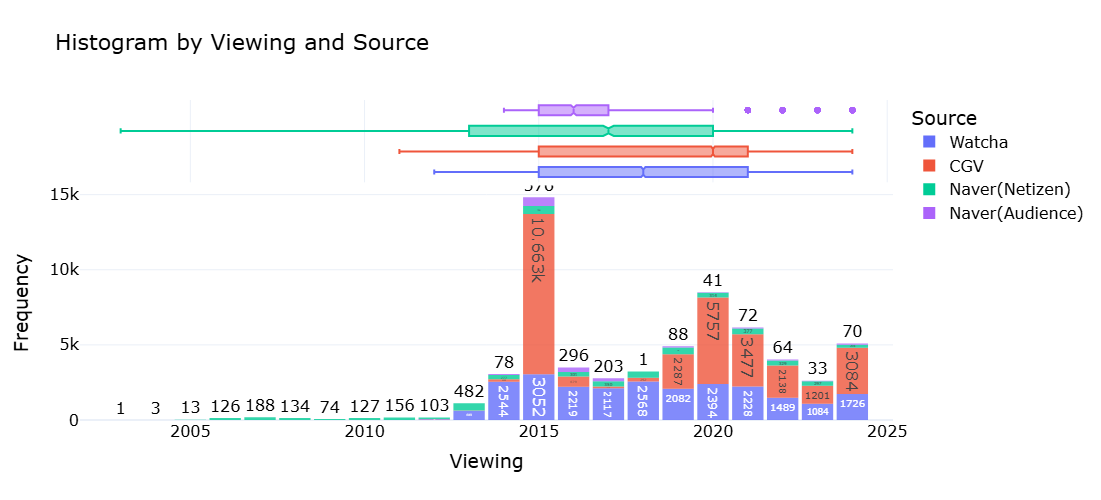

count       mean    std        min        25%        50%  \
Viewing 60,803.0000 2,018.3124 3.4260 2,003.0000 2,015.0000 2,019.0000   

               75%        max  
Viewing 2,021.0000 2,024.0000

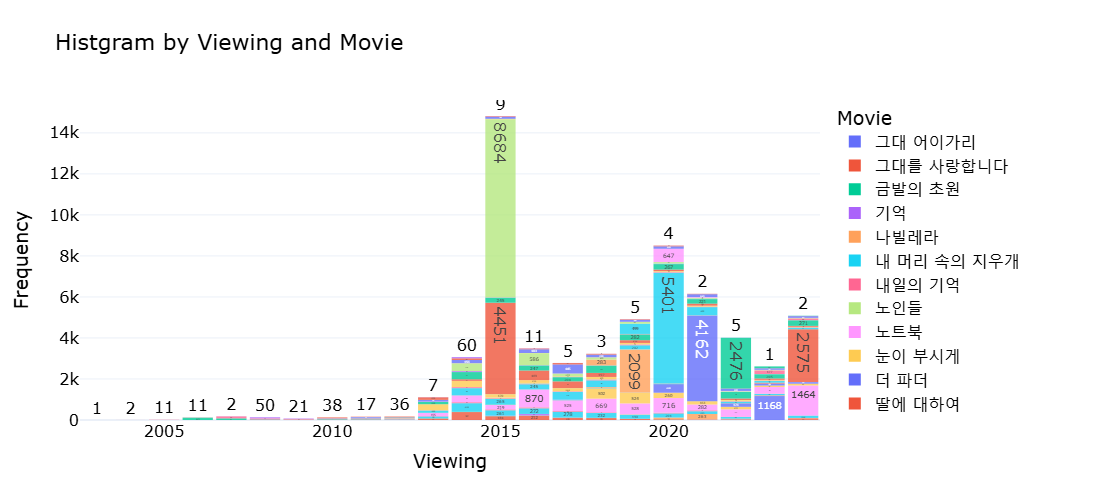

In [38]:
# 데이터 추세
## 연도별(리뷰) 소스별 리뷰의견수 추세
plot_histogram(df_freq, x='Viewing', color='Source', title='Histogram by Viewing and Source', marginal='box')
## 연도별(리뷰) 영화별 리뷰의견수 추세
plot_histogram(df_freq, x='Viewing', color='Movie', title='Histgram by Viewing and Movie')

count   mean     std    min    25%    50%    75%      max
Length 60,803.0000 6.6606 12.6072 1.0000 3.0000 4.0000 7.0000 952.0000

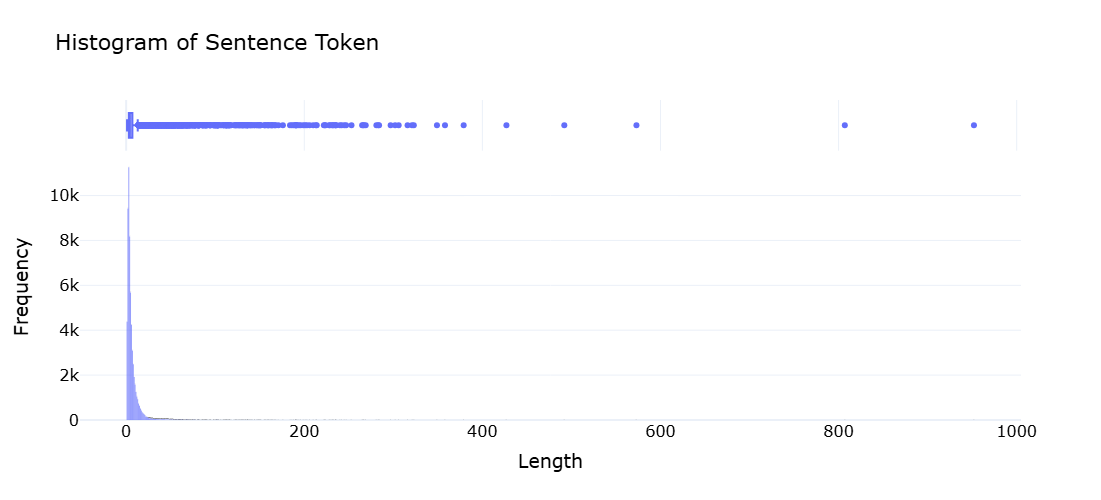

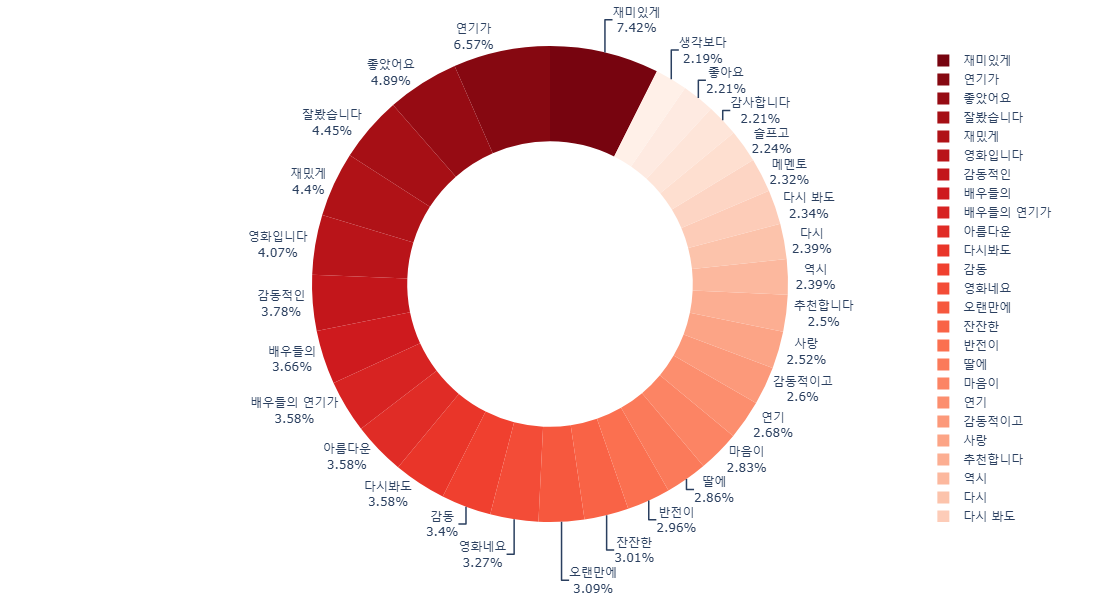

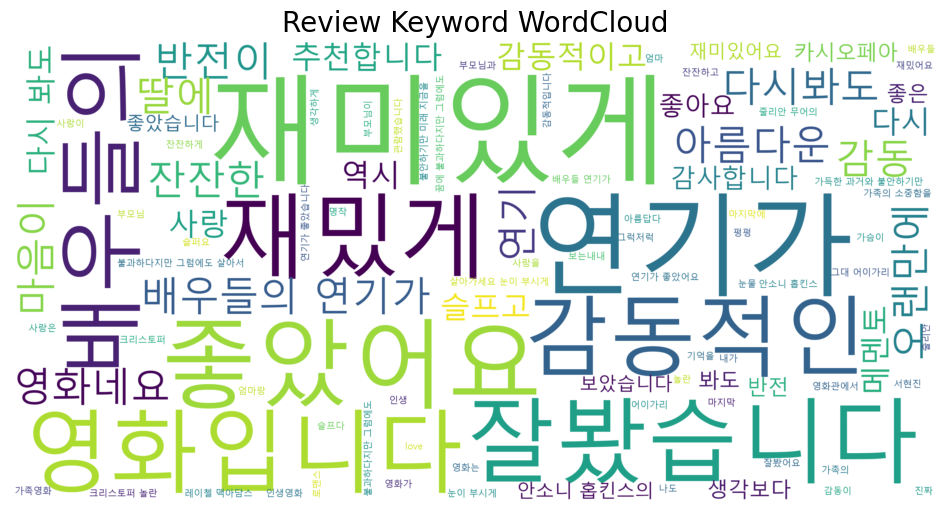

In [39]:
# 키워드 분포
## 리뷰문장 토큰 길이 분포
plot_histogram_senttoken(df_freq['Token_'+TOKENIZER]) 
## 전체기간 주요키워드 분포
plot_donut_wordfreq(word_freq)
plot_wordcloud(word_freq, title='Review Keyword WordCloud', max_font_size=50, save_local=False)
## 연도별(리뷰) 주요키워드 분포
plot_treemap_wordfreq(word_freq_categ)

## LDA

- Latent Dirichlet Allocation (LDA)는 토픽모델링에 이용되는 대표적인 알고리즘

> - 토픽 모델링이 제공하는 토픽은 어떤 주제를 구성하는 단어들인지로 정의되며,
> - 문서 집합에서 이 단어 집합을 찾아 우리의 문서가 어떤 토픽인지 알 수 있음

- LDA 모델을 학습하기 전에 몇 개의 토픽으로 나눌 것인지 먼저 결정해야 함

> - 일반적으로 (1) perplexity와 coherence를 함께 고려하여 결정 + (2) 정성적인 토픽 갯수 고려하여 결정
>> - perplexity: 모델이 얼마나 잘 예측하는지 나타내는 지표로, 낮은 perplexity 값은 모델이 문서에서 나타나는 단어를 더 잘 예측한다는 것을 의미
>> - coherence: 발견된 토픽이 얼마나 의미있는지 나타내는 지표로, 높은 coherence 값은 토픽 내 단어들이 서로 관련성이 높다는 것을 의미

- LDAvis

> (1) Intertopic Distance Map (via multidimensional scaling)
> - 각 토픽이 가진 고차원의 단어들을 PCA로 2차원 축소 시각화
> - 원크기: 토픽의 단어들이 얼마나 포함 및 분포되어 있는지
> - 원거리: 토픽간의 유사성 (2개의 원이 겹친다면 유사한 토픽이라는 의미)
>
> (2) Top-30 Most Relevant Terms for Topic
> - 토픽 별로 가장 자주 등장하는 단어들(람디=1)과 토픽 간 차이가 많이나는 단어들(람다=0)을 종합적으로 고려 

2025-02-07 23:00:22,817	INFO worker.py:1619 -- Calling ray.init() again after it has already been called.


Optimal Topic Number:  2


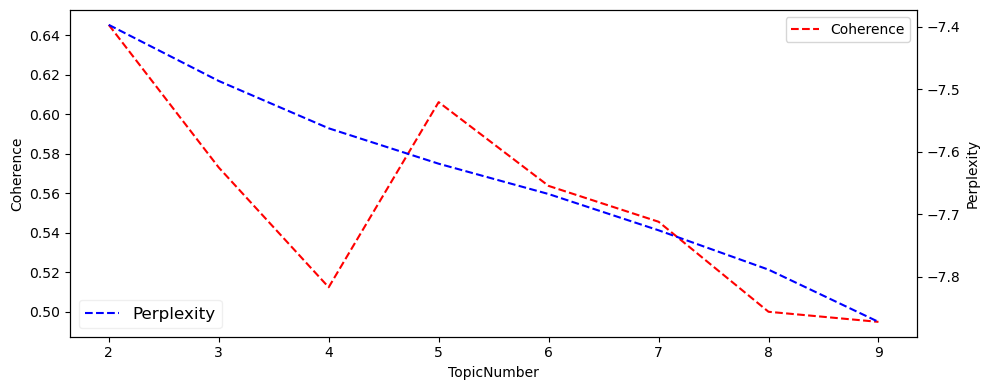

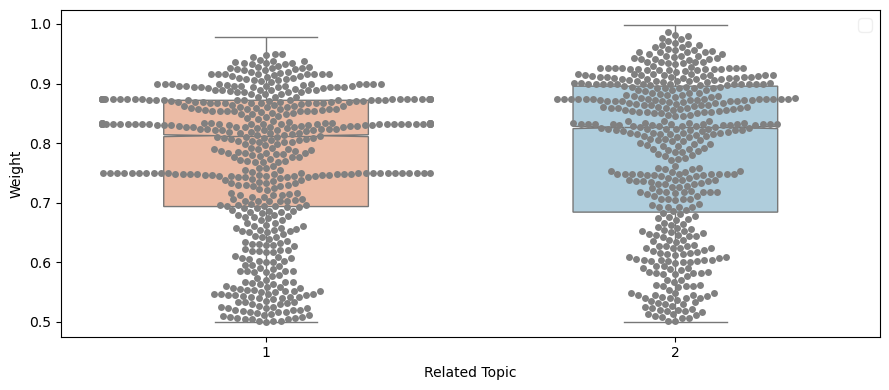

Related Keywords  \
Topic 1  '연기(22.5%)', '감동(20.2%)', '눈물(11.0%)', '서현진(9.2%)', '연기가(8.7%)', '반전(8.1%)', '진짜(5.8%)', '좋은(5.2...   
Topic 2  '사랑(28.6%)', '가족(11.1%)', '치매(9.5%)', '이야기(8.7%)', '지는(7.9%)', '기억(7.1%)', '가는(7.1%)', '마음(7.1%)...   

         Number of Sentences  Percentage  Average Probability  
Topic 1                30987      0.5096               0.7731  
Topic 2                29816      0.4904               0.7854

In [23]:
# 주요토픽 트랜드
## 원래의견 기준 LDA 최적화
save_name = SAVE_NAME_LDA.split('.')[0]+'_CommentPrepAuto(1,3)_Topic{}.xlsx'.format(NUM_TOPICS)

topic_kw_LDA, topic_doc_LDA, \
doc_topic_LDA, model_LDA = modeling_LDA(df_freq['Token_'+TOKENIZER], df_freq['Comment_Prep'],
                                        num_topics=NUM_TOPICS, num_topicwords=NUM_TOPICWORDS, num_topicsamples=NUM_TOPICSAMPLES,
                                        save_local=SAVE_LOCAL, save_name=save_name)
display(topic_kw_LDA)

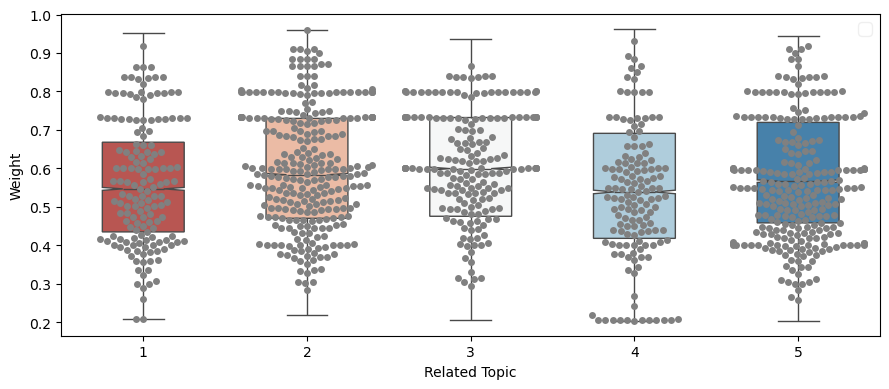

Related Keywords  \
Topic 1  '엄마(25.8%)', '아버지(12.5%)', '반전이(10.8%)', '재밌게(8.3%)', '사랑(8.3%)', '눈물(7.5%)', '있어(7.5%)', '연기(6....   
Topic 2  '사랑(26.1%)', '이야기(11.1%)', '가족(10.6%)', '치매(10.0%)', '기억(8.9%)', '가는(7.8%)', '지는(7.8%)', '알츠하이머(...   
Topic 3  '감동(28.5%)', '연기(24.8%)', '연기가(11.3%)', '서현진(8.2%)', '배우들의(5.3%)', '좋았어요(5.0%)', '배우님(4.7%)', '스...   
Topic 4  '사랑(19.5%)', '내가(12.0%)', '시를(10.5%)', '남자(9.8%)', '나를(9.0%)', '아름다운(9.0%)', '인생(8.3%)', '나는(7.5...   
Topic 5  '반전(19.1%)', '눈물(15.4%)', '많이(9.3%)', '보면(8.6%)', '최고(8.6%)', '진짜(8.0%)', '펑펑(8.0%)', '좋은(8.0%)'...   

         Number of Sentences  Percentage  Average Probability  
Topic 1                 9315      0.1532               0.5459  
Topic 2                16420      0.2701               0.5576  
Topic 3                11927      0.1962               0.5967  
Topic 4                 8572      0.1410               0.5798  
Topic 5                14569      0.2396               0.5941

Topic Number  Weight  \
919        Topic 1  0.9521   
7583       Topic 1  0.9513   
3277       Topic 1  0.9455   
45611      Topic 1  0.9367   
4          Topic 1  0.9323   
21533      Topic 2  0.9597   
58204      Topic 2  0.9594   
1219       Topic 2  0.9591   
977        Topic 2  0.9574   
35271      Topic 2  0.9551   
3493       Topic 3  0.9365   
59476      Topic 3  0.9329   
36013      Topic 3  0.9271   
59007      Topic 3  0.9194   
24135      Topic 3  0.9193   
3523       Topic 4  0.9631   
35240      Topic 4  0.9599   
10696      Topic 4  0.9477   
25171      Topic 4  0.9475   
7159       Topic 4  0.9446   
59051      Topic 5  0.9450   
1691       Topic 5  0.9380   
54509      Topic 5  0.9373   
21862      Topic 5  0.9372   
13222      Topic 5  0.9368   

                                                                                              Comment_Prep  
919              못만든 드라마도 이것보다는 잘만들었다 뻔하고도 예상대로 흘러가는 스토리에 실소만 나온다 거기다가 신파를 국악과 연결해서 감정을 울릴려고 같은데 전혀 아니올시다다  
7583                  내가 본 로맨스물중에 최고다  로맨스물봐도 아무런 감정없는데 이건 진짜 맘이 잔잔해졌고 나도 사랑 하고싶단 오글거리는 생각이 들게해줬다 나중에 또봐야지  
3277                            발레 라는 주제와 송강 이라는 배우에 보기 시작했는데 로맨스없는 드라마라 좋았다 송강을 로맨스 없이 쓰다니 패기있는 드라마였다 좋았다  
45611                                               가족애로 뻔한 감성을 끌어내는 영화들이 간혹 근데 나는 이걸 울었나했더니 결론은 박근형님 최고시다  
4                                           실제 비슷한 생활을 해본 조금은 어설프기도 공감하기 힘든 지루한 진행 자꾸 그걸 느끼라고 하는데  자꾸 느껴지는  
21533  이타심이 사람들만 세상에 존재하면 인간이란 평생을 이끌어갈 종이 될수도 있을텐데란 생각을 하게된다 사는 세상욕심 탐욕이것만 견제하고 남에게 피해만 안주면 되는것 아닌가하지만...  
58204      예측할 없었던 상황에서 혼자만의 생각으로 모든것을 거부하는 주인공과 주인공에게 당연한듯 예측할 없었던 따뜻함을 주는 가족들 가슴이 메어질정도로 안타깝고 슬픈 따뜻한 이야기  
1219                남녀의 사랑을 넘어서 사람과 사람의 사랑을 표현한 것같아서 따뜻하다 기억하고 싶은 명대사가 많았다 지금 생각나는 건 우리는 다시 부부가 되었다 가족이었는데  
977    모든 인간의 두려움이기도 치매라는 병 나의 마지막의 모습이게 될까봐 두려운 나약한 인간의 모습 인생의 허무함을 느껴보는 시간이 됨 억지 감정이입을 유도하는 듯한 교육용 시청...  
35271  삶의 존엄성을 위협하는 망각 자신을 기억하는 모든이들을 기억하지 못할 때의 비극적인 마음이 오롯히 전해졌다 명망있는 지성인으로 이룬 모든 성취와 업적들이 기억을 망각하는 유...  
3493                                             초반에 레이첼 맥아담스 마냥 사랑스러운 손예진이었고 후반엔 줄리엔 무어의 앨리스 연기에 다시금 감탄했다  
59476                                                       서현진 연기에 감동 배우들 연기 다 좋고 스토리 연출 다 좋아요 좋은영화 잘봤습니다  
36013                                                     배우들의 연기력이 좋다 줄리안 무어의 연기력에 감탄하고 크리스틴 스튜어트 연기에 놀랬다  
59007                                                          안성기 서현진 주예림 배우의 연기 담담해서 슬펐어요 마음을 울리는 영화였습니다  
24135                                                   시사회로 봤는데 가슴 뭉클해지고 좋았어요 많은걸 느끼게 해주는 감동적이고 좋은 영화였습니다  
3523   언니 그거 알아요 사람이 아름다운 걸 보면 기억을 잃는대요   언니 그거 알아요 사람이 아름다운 걸 보면 기억을 잃는대요   언니 그거 알아요 사람이 아름다운 걸 보면 기억...  
35240  rail able remember things moments day pure happiness joy think suffering suffering struggling st...  
10696  ill smile joy remember spent summer beneath trees learning growing love best love kind awakens s...  
25171  memory change shape room change color car memories distorted theyre interpretation theyre record...  
7159                                              노년의 모습만이 기억에 남는다 수없이 읽고 읽고 다시 읽고 당신과 순간이라도 다시 사랑하기 위해서라면  
59051                                            영화보는 내내 계속 울었습니다 내가 치매를 걸린다면 남겨진 가족에 대해 깊이 생각하게 되는 영화였습니다  
1691                                                   눈물 콧물 흘리며 원작을 봤다 영화를 보면서는 김수미할머니가 자꾸 걸려 집중을 할수가 없었다  
54509                                                      마지막에 진짜 엄청 울었다 보면서 부모님 생각도 많이 나고 박근형 쌤의 연기 최고였음  
21862  게이 트젠 bl 브로맨스는 되지만 워맨스 레즈비언은 지워버리는 사회에서 꿋꿋하게 레즈비언 영화를 만들어 개봉해주셔서 감사한지요 레즈비언 영화라 제외됐다는 소식듣고 속상했습니...  
13222                                               시간을 소재로 스토리상 오류가 보였으나 연기로 연출로 잊게해준 내내 웃고 울고 화낼수 있던 드라마

In [40]:
## 원래의견 기준 LDA 최종
NUM_TOPIC_FINAL = 5
save_name = SAVE_NAME_LDA.split('.')[0]+'_CommentPrepAuto(1,3)_Topic{}.xlsx'.format(NUM_TOPIC_FINAL)

topic_kw_LDA, topic_doc_LDA, \
doc_topic_LDA, model_LDA = modeling_LDA(df_freq['Token_'+TOKENIZER], df_freq['Comment_Prep'],
                                        num_topics=NUM_TOPIC_FINAL, num_topicwords=NUM_TOPICWORDS, num_topicsamples=NUM_TOPICSAMPLES,
                                        save_local=SAVE_LOCAL, save_name=save_name)
display(topic_kw_LDA, topic_doc_LDA)

In [ ]:
# ## 토픽별 워드클라우드
# word_freq_topic, wordadj_freq_topic, df_freq_topic = preprocessing_wordfreq(doc_topic_LDA, 
#                                                                             colname_target=TARGET+'_Prep', colname_category='Related Topic', 
#                                                                             ngram_range=NGRAM_RANGE,
#                                                                             tfidf_maxcol=TFIDF_MAXCOL, tfidf_dellowfreq=TFIDF_DELLOWFREQ,
#                                                                             keybert_topnkwd=KEYBERT_TOPNKWD,
#                                                                             sent2kwd_ray=RAY,
#                                                                             num_showkeyword=NUM_SHOWKEYWORD, 
#                                                                             save_local=SAVE_LOCAL, save_name=SAVE_NAME_PREP+'topic')

# for group in word_freq_topic[TOKENIZER]['category'].unique():
#     df_sub = word_freq_topic[word_freq_topic[TOKENIZER]['category'] == group]
#     plot_wordcloud(df_sub, title='Topic_'+str(group), max_font_size=50, save_local=False)

In [41]:
# 데이터결합: 원본+감성분석+토픽결과
df_freq_topic = pd.concat([df_freq, doc_topic_LDA.iloc[:,1:]], axis=1)

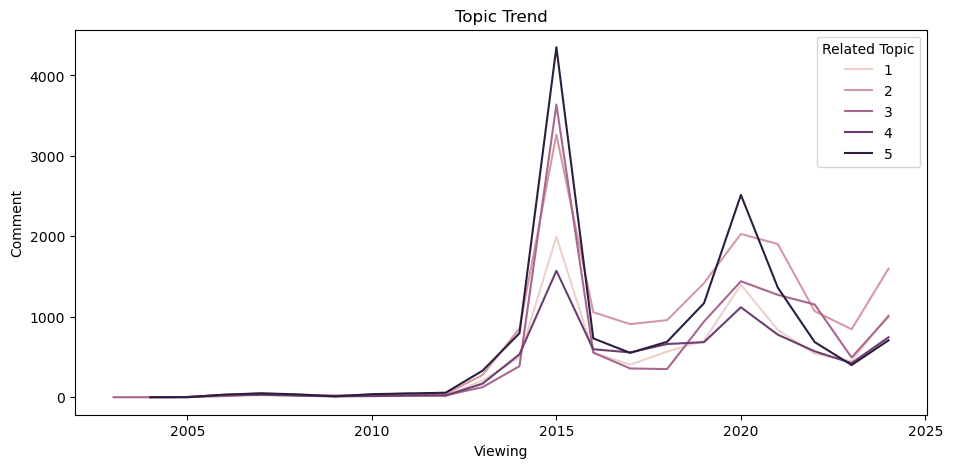

In [42]:
## 토픽 Hot & Cold 리뷰 트랜드
df_plot = df_freq_topic.groupby(['Viewing', 'Related Topic'])['Comment'].count().reset_index()
fig = plt.figure(figsize=(11, 5))
sns.lineplot(df_plot, x='Viewing', y='Comment', hue='Related Topic')
plt.title('Topic Trend')
plt.show()
# ## 토픽 Hot & Cold 확률분포 트랜드
# df_plot = df_freq_topic.groupby(['Viewing', 'Related Topic'])['Weight'].mean().reset_index()
# fig = plt.figure(figsize=(11, 5))
# sns.lineplot(df_plot, x='Viewing', y='Weight', hue='Related Topic')
# plt.title('Topic Trend')
# plt.show()

In [56]:
## 영화별 토픽 분포
df_topic_ratio, _ = LDA_resultstat(df_freq_topic, 'Movie', 'Related Topic', colname_prefix='Topic')
movie_topic2 = list(df_topic_ratio[np.argmax(df_topic_ratio, axis=1) == 1].index)

Topic Rank
Movie                             
그대 어이가리          3 > 2 > 5 > 1 > 4
그대를 사랑합니다        2 > 5 > 3 > 1 > 4
금발의 초원           2 > 5 > 4 > 1 > 3
기억               2 > 1 > 3 > 5 > 4
나빌레라             2 > 1 > 4 > 5 > 3
내 머리 속의 지우개      5 > 4 > 2 > 1 > 3
내일의 기억           2 > 5 > 4 > 3 > 1
노인들              2 > 4 > 1 > 3 > 5
노트북              2 > 4 > 1 > 3 > 5
눈이 부시게           2 > 5 > 1 > 4 > 3
더 파더             2 > 3 > 5 > 1 > 4
딸에 대하여           2 > 3 > 1 > 5 > 4
러블리, 스틸          5 > 2 > 1 > 4 > 3
레저 시커            2 > 4 > 1 > 3 > 5
로망               5 > 3 > 2 > 1 > 4
메멘토              5 > 2 > 3 > 1 > 4
사랑의 기적           2 > 5 > 4 > 3 > 1
살인자의 기억_복수       2 > 5 > 1 > 4 > 3
세비지스             2 > 1 > 5 > 4 > 3
세상에서 가장 아름다운 이별  5 > 1 > 2 > 4 > 3
소중한 사람           2 > 5 > 3 > 4 > 1
스틸 앨리스           2 > 3 > 4 > 5 > 1
시                2 > 4 > 1 > 5 > 3
어웨이 프롬 허         2 > 4 > 5 > 1 > 3
엄마의 공책           1 > 3 > 5 > 2 > 4
왓 데이 해드          2 > 5 > 3 > 1 > 4
이터널 메모리          2 > 4 > 5 > 3 > 1
장수상회             5 > 3 > 1 > 2 > 4
조금씩, 천천히 안녕      2 > 5 > 1 > 3 > 4
천일의 약속           2 > 5 > 4 > 1 > 3
첫 키스만 50번째       2 > 4 > 5 > 1 > 3
친정엄마             5 > 1 > 3 > 2 > 4
카시오페아            3 > 2 > 5 > 1 > 4
해피엔딩 프로젝트        2 > 1 > 5 > 4 > 3

In [45]:
# 주요토픽별 감성(Rating) 트랜드
## 영화별 감성 분포
df_rating_binary_ratio, _ = LDA_resultstat(df_freq_topic, 'Movie', 'Rating_Binary', colname_prefix='Rating')

Rating Rank
Movie                      
그대 어이가리          1 > 0 > -1
그대를 사랑합니다        0 > 1 > -1
금발의 초원           1 > 0 > -1
기억               0 > -1 > 1
나빌레라                 0 > -1
내 머리 속의 지우개      0 > -1 > 1
내일의 기억           0 > 1 > -1
노인들              0 > -1 > 1
노트북              0 > -1 > 1
눈이 부시게               0 > -1
더 파더             0 > 1 > -1
딸에 대하여           0 > 1 > -1
러블리, 스틸          0 > 1 > -1
레저 시커                0 > -1
로망               1 > 0 > -1
메멘토              0 > 1 > -1
사랑의 기적           0 > 1 > -1
살인자의 기억_복수       0 > -1 > 1
세비지스                 0 > -1
세상에서 가장 아름다운 이별  0 > 1 > -1
소중한 사람           1 > 0 > -1
스틸 앨리스           0 > 1 > -1
시                0 > 1 > -1
어웨이 프롬 허         0 > 1 > -1
엄마의 공책           1 > 0 > -1
왓 데이 해드          0 > 1 > -1
이터널 메모리          0 > 1 > -1
장수상회             1 > 0 > -1
조금씩, 천천히 안녕      0 > 1 > -1
천일의 약속               0 > -1
첫 키스만 50번째       0 > 1 > -1
친정엄마             1 > 0 > -1
카시오페아            1 > 0 > -1
해피엔딩 프로젝트        0 > 1 > -1

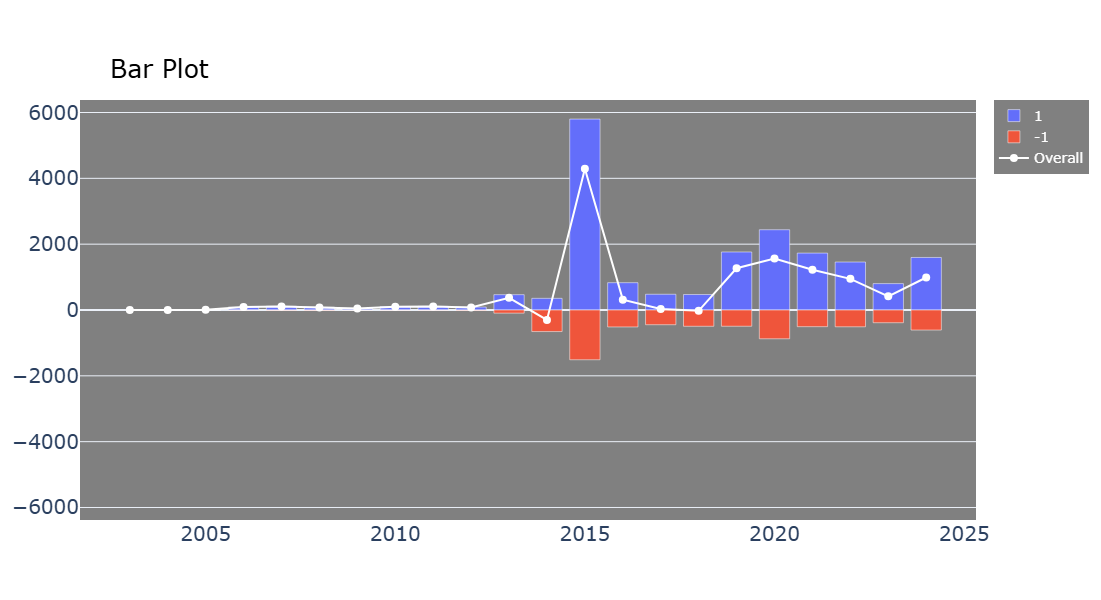

In [61]:
## 연도별 감성 긍부정 트랜드
df_sent_time = df_freq_topic.groupby('Viewing')[['Rating_Binary']].value_counts().unstack().loc[:,[-1,1]]
df_sent_time = df_sent_time[[1,-1]]
df_sent_time.iloc[:,1] = df_sent_time.iloc[:,1] * -1
plot_bar(df_sent_time, summation=True, save_local=False)

1


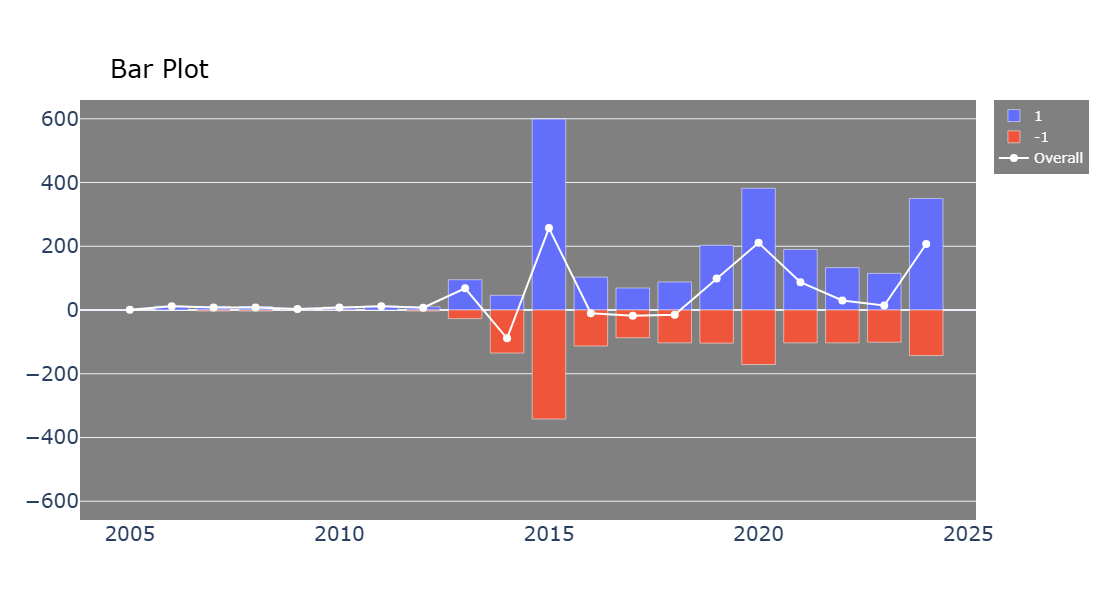

2


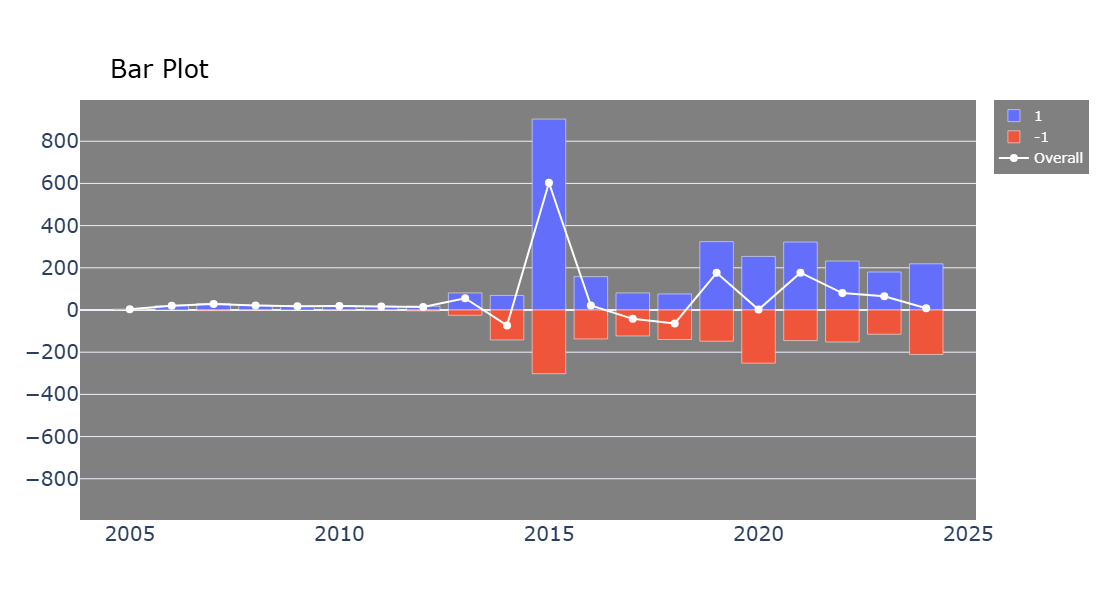

3


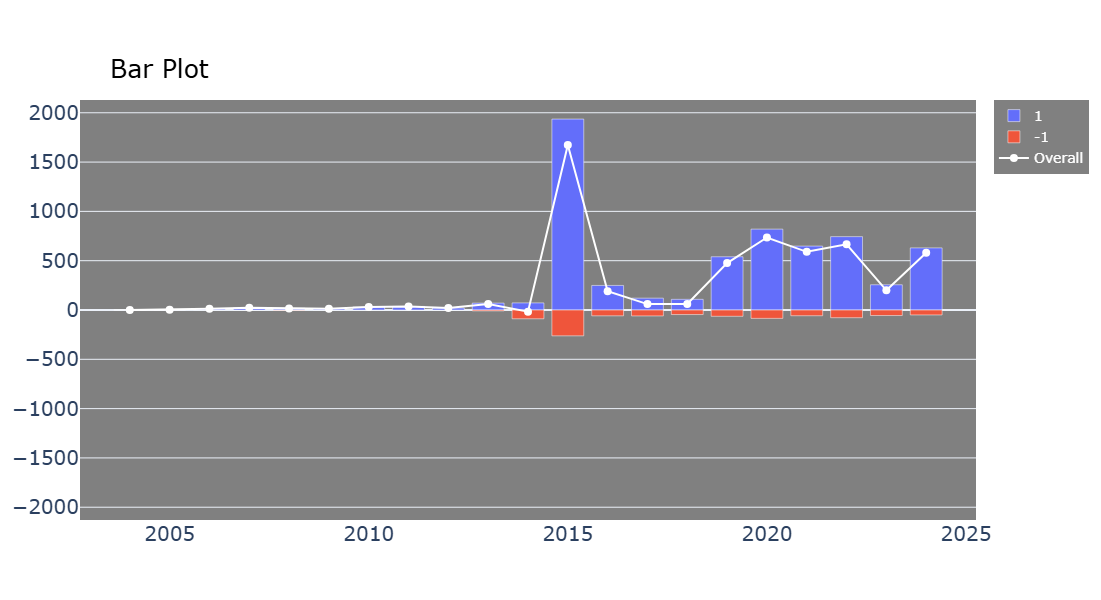

4


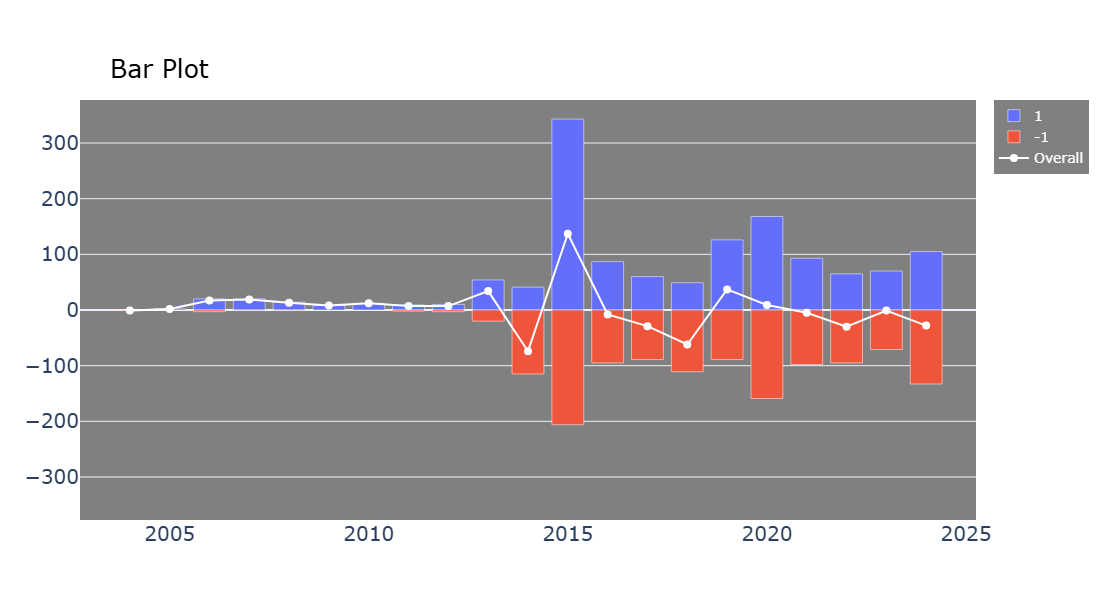

5


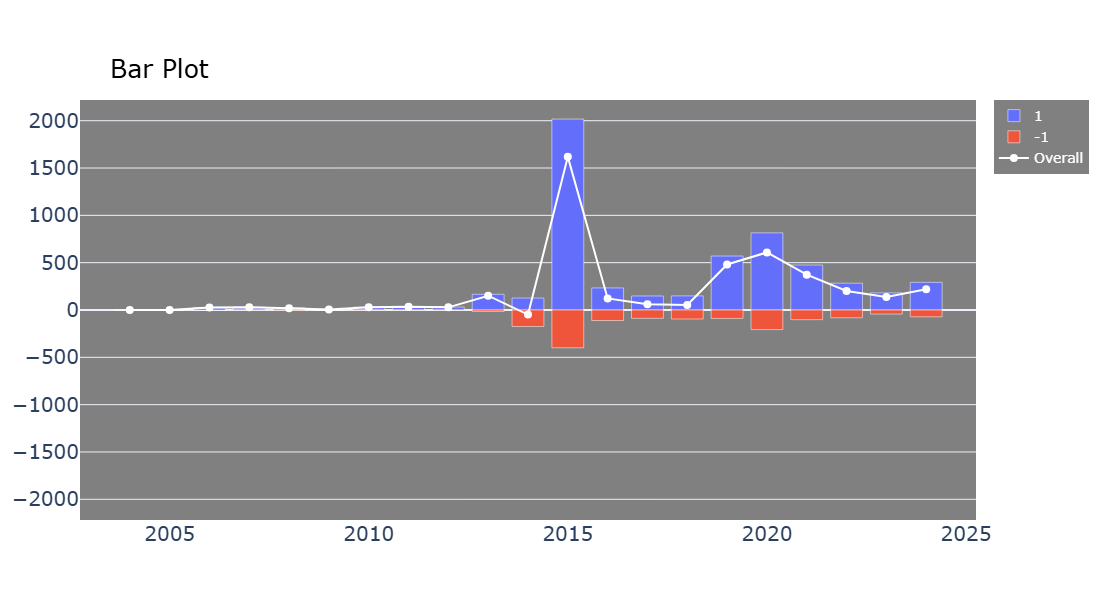

In [70]:
## 토픽별 감성 긍부정 트랜드
for topic in sorted(df_freq_topic['Related Topic'].unique()):
    print(topic)
    df_sub = df_freq_topic[df_freq_topic['Related Topic'] == topic].reset_index().iloc[:,1:]
    df_sub_time = df_sub[df_sub.Rating_Binary != 0].groupby('Viewing')[['Rating_Binary']].value_counts().unstack()
    df_sub_time = df_sub_time[[1,-1]]
    df_sub_time.iloc[:,1] = df_sub_time.iloc[:,1] * -1
    plot_bar(df_sub_time, summation=True, save_local=False)

# Others

In [80]:
## 치매관련 영화기준 치매주제의 평점 긍부정 트랜드
movie_filter_num = 3
for topic in sorted(df_freq_topic['Related Topic'].unique()):
    if topic == 2:
        df_sub = df_freq_topic[df_freq_topic.Movie.isin(movie_topic2)].reset_index().iloc[:,1:]    # 치매영화 필터
        df_sub = df_sub[df_sub['Related Topic'] == topic].reset_index().iloc[:,1:]    # 치매주제 필터
        # df_sub = df_freq_topic[df_freq_topic['Related Topic'] == topic].reset_index().iloc[:,1:]
        df_group = df_sub[df_sub.Rating_Binary != 0].groupby(['Movie'])[['Rating_Binary']].sum()
        movie_posi = list(df_group[df_group>=0].dropna().index)
        movie_nega = list(df_group[df_group<0].dropna().index)
        display(df_group.loc[movie_posi,:].sort_values(by='Rating_Binary', ascending=False).T)
        display(df_group.loc[movie_nega,:].sort_values(by='Rating_Binary', ascending=False).T)
        movie_posi = list(df_group.loc[movie_posi,:].sort_values(by='Rating_Binary', ascending=False).index[:movie_filter_num])
        movie_nega = list(df_group.loc[movie_nega,:].sort_values(by='Rating_Binary', ascending=False).index[-movie_filter_num:])
        print(movie_posi, movie_nega)

Movie          스틸 앨리스  더 파더  딸에 대하여  금발의 초원  왓 데이 해드  사랑의 기적  조금씩, 천천히 안녕  \
Rating_Binary     243   230      61      40       37      26           26   

Movie          내일의 기억   시  어웨이 프롬 허  해피엔딩 프로젝트  소중한 사람  그대를 사랑합니다  
Rating_Binary      25  18        15         14       7          4

Movie          노인들  천일의 약속  기억  세비지스  레저 시커  살인자의 기억_복수  이터널 메모리  나빌레라  \
Rating_Binary   -1      -2  -3    -4     -6          -8       -8   -10   

Movie          눈이 부시게  첫 키스만 50번째  노트북  
Rating_Binary     -24         -38 -255

['스틸 앨리스', '더 파더', '딸에 대하여'] ['눈이 부시게', '첫 키스만 50번째', '노트북']


In [81]:
## 감성에 따른 데이터분리
df_freq_topic_posi = df_freq_topic[df_freq_topic.Movie.isin(movie_posi)]
df_freq_topic_posi = df_freq_topic_posi[df_freq_topic_posi.Rating_Binary == 1].reset_index().iloc[:,1:]
df_freq_topic_nega = df_freq_topic[df_freq_topic.Movie.isin(movie_nega)]
df_freq_topic_nega = df_freq_topic_nega[df_freq_topic_nega.Rating_Binary == -1].reset_index().iloc[:,1:]

[Kss]: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy


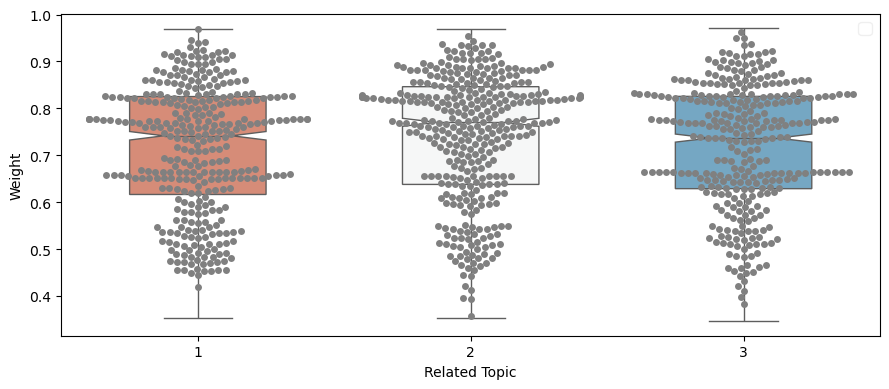

Related Keywords  \
Topic 1  '연기(22.4%)', '감동(18.0%)', '무어(9.8%)', '앨리스(9.3%)', '아름다운(7.7%)', '영화다(7.7%)', '사랑(7.7%)', '다시(6....   
Topic 2  '연기(15.3%)', '연기가(11.8%)', '대해(11.8%)', '생각(9.7%)', '좋았다(9.7%)', '인생(8.3%)', '내용(8.3%)', '무어(8.3...   
Topic 3  '알츠하이머(15.9%)', '영화입니다(13.8%)', '사랑(10.1%)', '가족(9.4%)', '연기(9.4%)', '앨리스(9.4%)', '모습을(8.7%)', '...   

         Number of Sentences  Percentage  Average Probability  
Topic 1                 1302      0.3204               0.7384  
Topic 2                 1474      0.3627               0.7143  
Topic 3                 1288      0.3169               0.7160

Topic Number  Weight  \
4006      Topic 1  0.9685   
1309      Topic 1  0.9671   
1319      Topic 1  0.9651   
1750      Topic 1  0.9651   
4061      Topic 1  0.9626   
2467      Topic 2  0.9689   
2283      Topic 2  0.9662   
1817      Topic 2  0.9639   
1203      Topic 2  0.9620   
337       Topic 2  0.9619   
3715      Topic 3  0.9706   
720       Topic 3  0.9690   
1318      Topic 3  0.9674   
1300      Topic 3  0.9630   
489       Topic 3  0.9599   

                                                                                                  Comment  
4006  역시 줄리언무어의 연기와 매력에 집중하게 했다. 알츠하이머와는 별개로  삶 전반적으로 공감가는 부분이 많았다. 크리스틴 스튜어트의 매력 또한 봐도봐도 새롭다. 잔잔하게 일상...  
1309  그 누구도 믿지 못하게 되는 공포, 시공간이 뒤틀리는 경험의 공포, 자신의 기억과 보여지는 현상 사이의 괴리에서 느껴지는 공포, 결국 더이상 무슨 일이 벌어지고 있는지 모르...  
1319  우연히 채널을 돌리다가 본 작품.. 루즈함보다는? 현실의 무서움? ㅜㅜ 반전은 관객이 다 알고있는 그대로 흐른다.. 조연들의 연기가 압권이었다.. 한정된 공간.. 한정된 사...  
1750  잔잔해서 지루하려나 했는데 어느순간 나도 모르게 영화속에 들어가 있는 느낌.. 배우들의 연기도 감독의 연출도 너무 좋았던 영화 특히 화장실에서 모녀가 나누는 대화에서는 나도...  
4061    한 인간 존재의 상실의 과정을 섬세하게 다룬 영화다. 기억과 지성의 상실은 정체성의 상실로 이어지는 것인가? 성숙한 사랑의 자세는 무엇인가? 여러가지 질문을 안겨주는 영화다.  
2467  인간애 대해서 깊이 있게 생각할 수 있는 영화를 만난것 같아 좋았다.여러가지 생각을 영화를 보는내내 하게 되었고 끝나고  난 뒤에도 많은 생각을 할 수 있게 되었다.얼마전 ...  
2283  오민애 배우의 잔잔한 연기가 마음 속에 오래 남아요. 요양보호사로서 최선을 다하는 모습에 뭉클했어요. '나이가 들어서 쓸모 없어지면 사회적으로 버림받느거냐'며 따지듯 묻는 ...  
1817  국민엄마로 등극하고 계시는 오민애 배우님의 연기 너무 좋네요! 최근에 본 세 편의 영화에서 각기 다른 캐릭터의 엄마를 연기하셨는데 모두 다 빙의모드이신게 신기해요. 봄날의 ...  
1203  와 역시 기대했던 대로였어요! 대배우 안소니 홉킨스님 연기 그 자체만으로도 흡입력 쩌는 영화ㅜㅠㅠㅠㅜ 소리치실때도 박력이 아주,,, 엄지척, 결말도 여운이 남고 연출도 살짝...  
337   정말 좋았어요. 이 영화는 안소니 홉킨스 할아버지를 위해 다시 각색을 한 영화라고 합니다. 연로하신 부모님을 생각하게 합니다. 정말 현실적이어서 가슴에 와 닿아 눈물이 났습...  
3715  지금 내 나이 스물넷. 나중에 내가 치매나 알츠하이머 걸린다고 하더라도 가족들로부터 사랑 받을 수 있을까? 꿈을 향해 달려가고 있을 때 아내가 저런 심각한 병 걸린다면 그녀...  
720   환자에게는 가장 행복한 병, 가족에게는 가장 고통스러운 병~그것은 치매입니다.이 영화는 치매환자의 1인칭시점에서 너무도 완벽하게 잘표현한 영화입니다. 치매를 모른다면 재미없...  
1318  안소니, 이름도 생년월일도 같게 한 것은 치매 걸린 노인을 이해 하는게 아니라 그대로 받아들이라는 것 같음. 안소니가 보는 그대로를 받아들이는게 바로 치매를 이해하는게 아닐...  
1300  영화를 보고 나니 치매가 더 두렵다.. 요양원인지, 요양병원인지.. 칠순이 넘으신 나의 아빠는 지금도 연세에 비해 무척 건강하시지만, 내가 어렸던 아주 오래 전부터 지금까지...  
489   시간과 기억의 혼돈.. 알츠하이머에 대해서 감히 상상도 할수 없지만 조금이나마 간잡체험이 되어 마음이 아팠습니다..단연 홉킨스의 불안하고 두려운 눈빛연기와 얼굴의 작은 떨림...

[Kss]: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy


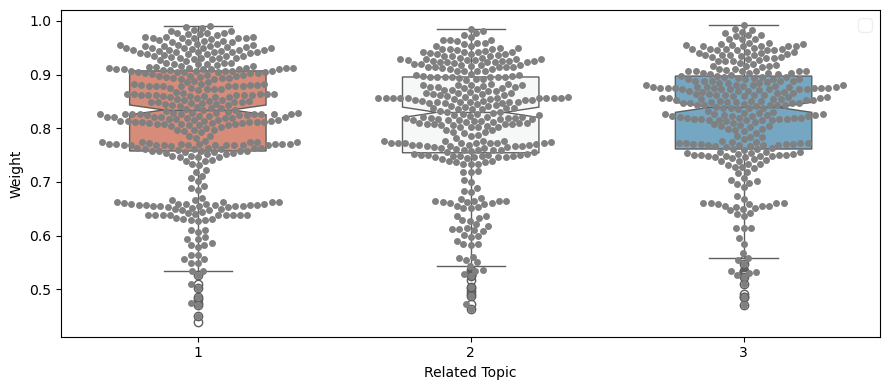

Related Keywords  \
Topic 1  '사랑(55.9%)', '노아(7.0%)', '노트북(5.6%)', '다시(4.9%)', '나는(4.9%)', '로맨스(4.9%)', '레이첼(4.2%)', '이야기(4.2...   
Topic 2  '사랑(16.7%)', '로맨스(12.5%)', '이야기(12.5%)', '없는(9.4%)', '남주(9.4%)', '맥아담스(9.4%)', '내가(8.3%)', '불륜(7...   
Topic 3  '사랑(39.8%)', '노아(8.5%)', '앨리(8.5%)', '로맨스(7.6%)', '스토리(7.6%)', '이야기(6.8%)', '없는(5.9%)', '남자(5.1%...   

         Number of Sentences  Percentage  Average Probability  
Topic 1                  655      0.3867               0.8159  
Topic 2                  521      0.3076               0.8102  
Topic 3                  518      0.3058               0.8196

Topic Number  Weight  \
442       Topic 1  0.9896   
820       Topic 1  0.9885   
680       Topic 1  0.9875   
974       Topic 1  0.9852   
6         Topic 1  0.9850   
738       Topic 2  0.9846   
1313      Topic 2  0.9814   
1014      Topic 2  0.9802   
878       Topic 2  0.9772   
1087      Topic 2  0.9745   
1289      Topic 3  0.9925   
1394      Topic 3  0.9842   
49        Topic 3  0.9834   
5         Topic 3  0.9797   
950       Topic 3  0.9783   

                                                                                                  Comment  
442   내가 하면 로맨스 . 앨리의 시점에서 영화를  본다면 충분히 가슴 아린 사랑 이야기다 첫사랑과 생이별도 모자라 다른사람과 약혼까지 한 뒤 첫사랑을 다시 만나게 되다니 이건 ...  
820   라이언 고슬링 인기 많은 거 이해 못했는데 처음으로 이해함 엘리 너무 사랑스럽고 노아랑 너무 귀엽게 사겼는데 부모님이 반대한 건 인정 그 때 바로 이어졌으면 솔직히 현실적 ...  
680   “한 사람을 지극히 사랑했으니  내 인생은 성공한 인생입니다” 로맨스 영화중 레전드가 아닐까.. 사실 부모님이 사랑하신 모습과 비슷한 스토리라 마음에 오래 남음. 고집세고 ...  
974   솔직히 왜 유명한지 모르겠다 보면서 나만 론 입장 생각한건가 분명 주인공들 입장에서야 첫사랑이고 늙을 때까지 변함 없는 사랑이겠지만 론 입장에서는 결혼식 앞두고 예비신부가 ...  
6     "운명적 사랑을 대신할 조건은 우리가 크고 작은 사랑을 하고 있다는 전제가 아닌 지금 마주보고 있는 그 사람에 대한 흔들림 없는 태도"       떨어져 있어도 서로만을 생...  
738   * 의도치 않게 오늘 라이언 고슬링 나오는 영화만 보네..  1. 에 이게 가능하다고??? 했는데 예??? 실화기반 소설이 원작이라구요??? 예…??? 진짜 드라마보다 더 ...  
1313  내 삶은, 때로는 불행했고 때로는 행복했습니다. 삶이 한낱 꿈에 불과하다지만 그럼에도 살아서 좋았습니다. 새벽의 쨍한 차가운 공기, 꽃이 피기 전 부는 달큰한 바람, 해질 ...  
1014  철 없이 이쁘고 부유한 소녀가 가진거 없이 열정과 순수한 사랑만 있는 남자를 만나는 내용인거면 남주인공을 조금 더 멋있게 풀어줬으면 서브남주를 선택하지 않고 주인공을 선택한...  
878   남성향 판타지 덕지덕지 묻은 로맨스 . 여주는 도시에서 온 부잣집 딸이지만 보잘것 없는 남주를 무조건 사랑해줘야 함 . 잘생기고 부자인 서브남주랑 약혼할 때마저도 여주는 남...  
1087  이게 그렇게 인생 영화라는 사람이 많던데  뭔가 모르게 보고 싶지 않아서 이제야 보게 되었다. 레이첼 맥아담스가 정말 예쁘게 나온다는 것만으로도 볼 가치가 충분했고 , 이야...  
1289  너무 좋다는 말밖에. 아프다는 말밖에 . 노인과 젊은이 가족,친구... 모든 사람을 아우르는 얘기. 특히 노인들의 이야기가 필요했다. 결국 내가 가야할 겪게될 지점이니까. ...  
1394  아담 샌들러의 외모에서 풍기는  인간미가 더욱 돋보이는 작품이었다. 일생의 여자를 만난다고 해서  누구나 그런 노력을 끊임없이  기울이는 건 아니니까.  바다코끼리며 펭귄과...  
49    영화는 기본적으로 허구에 기반하고 허구가 아니라고 하더라고 허구처럼 드라마틱 해야 영화의 소재가 된다. 첫사랑이 많은 고통을 통해서 결국 이루어 지고 사랑하는 사람과 한날 ...  
5     ....? 눈물 콧물 쏙 빼는 로맨스 영화로 유명해서 그렇게 기대를 했건만 너무 당황스럽네.. 당최 어디서 울어야 할지도 모르겠고 어디가 그렇게 로맨틱했는지도 모르겠어.. ...  
950   도입부에 해피 엔딩을 선언한 뒤, 클리셰로 점철된 길을 한 치의 오차 없이 따라가는 모범생 로맨스. 사랑스러운 두 주연 배우의 매력과 호흡은 아주 훌륭하나, 그것만으로 스토...

In [82]:
## 긍정영화 LDA 주제어
NUM_TOPIC = 3
save_name = SAVE_NAME_LDA.split('.')[0]+'_CommentPrepAuto(1,3)_SentiPosi_Topic{}.xlsx'.format(NUM_TOPIC)

topic_kw_LDA, topic_doc_LDA, \
doc_topic_LDA, model_LDA = modeling_LDA(df_freq_topic_posi['Token_'+TOKENIZER], df_freq_topic_posi['Comment'],
                                        num_topics=NUM_TOPIC, num_topicwords=NUM_TOPICWORDS, num_topicsamples=NUM_TOPICSAMPLES,
                                        save_local=SAVE_LOCAL, save_name=save_name)
display(topic_kw_LDA, topic_doc_LDA)

## 부정영화 LDA 주제어
NUM_TOPIC = 3
save_name = SAVE_NAME_LDA.split('.')[0]+'_CommentPrepAuto(1,3)_SentiNega_Topic{}.xlsx'.format(NUM_TOPIC)

topic_kw_LDA, topic_doc_LDA, \
doc_topic_LDA, model_LDA = modeling_LDA(df_freq_topic_nega['Token_'+TOKENIZER], df_freq_topic_nega['Comment'],
                                        num_topics=NUM_TOPIC, num_topicwords=NUM_TOPICWORDS, num_topicsamples=NUM_TOPICSAMPLES,
                                        save_local=SAVE_LOCAL, save_name=save_name)
display(topic_kw_LDA, topic_doc_LDA)

## BERTopic

In [11]:
# # 원래의견 기준 BERTopic
# save_name = SAVE_NAME_BERTopic.split('.')[0]+'_CommentAuto(1,2).xlsx'
# NUM_TOPICS_BERT = topic_kw_LDA.shape[0]

# topic_kw_BERT, topic_doc_BERT, \
# doc_topic_BERT, model_BERT = modeling_BERTopic(df_freq['Comment'], vectorizer_type='tfidf', 
#                                                ngram_range=NGRAM_RANGE,
#                                                tfidf_maxcol=TFIDF_MAXCOL, 
#                                                # umap_metric=UMAP_METRIC, umap_randomseed=UMAP_SEED,
#                                                num_topics=NUM_TOPICS_BERT, num_topicwords=NUM_TOPICWORDS, num_topicsamples=NUM_TOPICSAMPLES,
#                                                save_local=SAVE_LOCAL, save_name=save_name)
# display(topic_kw_BERT, topic_doc_BERT, doc_topic_BERT)

In [12]:
# # 토픽 유사성 구조 시각화
# model_BERT.visualize_topics()

In [13]:
# # Topic 별 Hierarchy를 출력하여 대략적 Topic의 갯수를 가늠하기 용이함
# model_BERT.visualize_hierarchy(top_n_topics=50)

In [14]:
# # Topic을 대표하는 상위 단어 5개씩 출력
# model_BERT.visualize_barchart(top_n_topics=50)

In [15]:
# # Topic간 유사도를 Cosine Similarity로 계산후 Heatmap으로 표현
# model_BERT.visualize_heatmap()

In [16]:
# # 일자별로 어떤 토픽이 증가하고 줄어들었는지 트랜드 파악
# topics_over_time = model_BERT.topics_over_time(docs=df['Comment'], timestamps=df.Date.to_list(), 
#                                                global_tuning=True, evolution_tuning=True)
# model_BERT.visualize_topics_over_time(topics_over_time, top_n_topics=50)

In [17]:
# # Topic내 대표하는 단어들에 대해서 c-tf-idf로 계산해서 각 단어가 Topic에서 차지하는 중요도를 계산했던 것을 Rank 순서대로 출력
# model_BERT.visualize_term_rank()